In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor
import time

plt.rcParams.update({'font.size': 14})
# pd.set_option('display.float_format', lambda x: '%.2e' % x)

In [2]:
data = simplesim.Manager( directory="./resistivity-new-data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="resistivity-new-diag", filetype="nc")

In [3]:
content = diag.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for pp in content:
    
    print( diag.outfile( pp), " split into ", diag.count( pp), " file(s)", i,
          "tau", pp["physical"]["tau"], "res", pp["physical"]["resistivity"])
    i+=1

The database contains 12 simulations
resistivity-new-diag/1f1ab687243422011a4b80ed9684a5e0cd49477a.nc  split into  7  file(s) 0 tau 0 res 1e-05
resistivity-new-diag/2fee6c9244f095a4c348e5c9bb8a12a57e10786e.nc  split into  7  file(s) 1 tau 1 res 3e-06
resistivity-new-diag/3ec81972a93bd5b7efb96fff8f32a128e879b6ea.nc  split into  10  file(s) 2 tau 1 res 0.0001
resistivity-new-diag/5a1869d7ed70394c1bd05e9c610623517269179d.nc  split into  7  file(s) 3 tau 0 res 3e-06
resistivity-new-diag/7f852ba3d56765383228e963268ee9593583c96e.nc  split into  9  file(s) 4 tau 0 res 0.0001
resistivity-new-diag/8ff727a75b374aeb38e1093af32542ef213cc1fe.nc  split into  10  file(s) 5 tau 1 res 0.0003
resistivity-new-diag/a658b772ad9f39a9a2e6a026c0c6db8cd0177299.nc  split into  7  file(s) 6 tau 1 res 1e-06
resistivity-new-diag/a9c2c59b90af00fe9a0ecc143e930168a528f06e.nc  split into  10  file(s) 7 tau 1 res 3e-05
resistivity-new-diag/bb9743ce9505b22bf7474671f3ecef8a340e83bf.nc  split into  7  file(s) 8 tau 1 res 

In [4]:
def create_merged_dataset( manager, params ) :
    datasetpaths = [manager.outfile(params,i) for i in range(manager.count(params))]
    return xfeltor.open_feltordataset( datasetpaths)


In [5]:
# This cell may take a minute ...
content = diag.table()
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    file = create_merged_dataset( diag, pp)
    pp['file'] = file
    

1e-05 0
3e-06 1
0.0001 1
3e-06 0
0.0001 0
0.0003 1
1e-06 1
3e-05 1
1e-05 1
3e-05 0
1e-06 0
0.0003 0


In [6]:
da0 = Dataset( diag.files()[0]['outputfile']) # All Sims use the same magnetic field
for pp in content : # modifying pp modifies content
    print( pp['physical']['resistivity'], pp['physical']['tau'])
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
    
    pp['rho'] = da0['rho'][:]
    pp['rho_t'] = da0['rho_t'][:]
    pp['rho_p'] = da0['rho_p'][:]
    pp['lcfs'] = np.argmax( pp['rho_t'][np.where( pp['rho_t'] < 1)])
    pp['area'] = da0['psi_area'][:]
    pp['volume'] = da0['psi_vol'][:]

1e-05 0
3e-06 1
0.0001 1
3e-06 0
0.0001 0
0.0003 1
1e-06 1
3e-05 1
1e-05 1
3e-05 0
1e-06 0
0.0003 0


In [7]:
# sort parameters
content = sorted(content, key=lambda pp: (pp['physical']['resistivity'], pp['physical']['tau']))
for pp in content :
    print( pp['physical']['resistivity'], pp['physical']['tau'])


1e-06 0
1e-06 1
3e-06 0
3e-06 1
1e-05 0
1e-05 1
3e-05 0
3e-05 1
0.0001 0
0.0001 1
0.0003 0
0.0003 1


In [8]:
# drop last index in one sim because it crashed
# USE ONLY ONCE
for pp in content :
    if pp['physical']['resistivity'] == 1e-4 and  pp['physical']['tau'] == 0 :
        pp['file'] = pp['file'].drop_isel(time = [-1])
#     if pp['physical']['resistivity'] == 1e-6 and  pp['physical']['tau'] == 1 :
#         pp['file'] = pp['file'].drop_isel(time = [-1])
#     if pp['physical']['resistivity'] == 3e-6 and  pp['physical']['tau'] == 1 :
#         pp['file'] = pp['file'].drop_isel(time = [-1])
#         print( pp['physical']['resistivity'], pp['physical']['tau'])
#         print( pp['file'])

In [9]:
min_idx_dict = {
    0 : {1e-6: 300, 1e-4 : 250 , 1e-5 : 300, 3e-6: 300, 3e-5 : 300, 3e-4: 150},
    1 : {1e-6: 200, 1e-4 : 200 , 1e-5 : 200, 3e-6: 200, 3e-5 : 300, 3e-4: 150}          
} # in cs/R0

### Mass flux out of separatrix

Average flux is 3.68e-04 pm 1.10e-04
Total average mass loss rate is 1824.6
Total mass gain by sources is 2096.9
particle confinement time = 2.04e+01


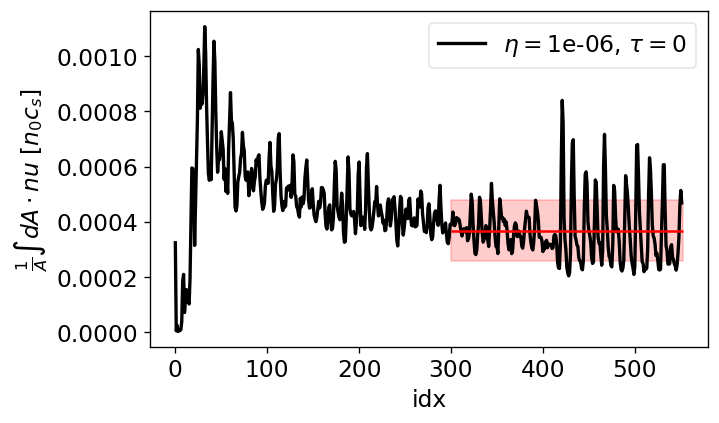

Average flux is 3.71e-04 pm 1.82e-04
Total average mass loss rate is 1841.6
Total mass gain by sources is 2096.9
particle confinement time = 1.97e+01


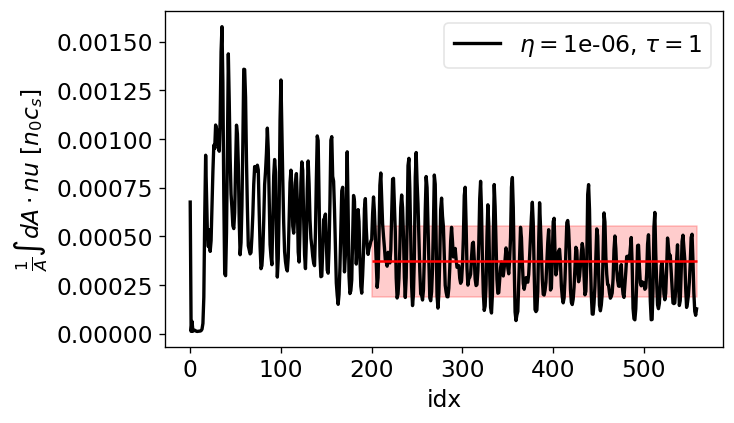

Average flux is 3.87e-04 pm 6.74e-05
Total average mass loss rate is 1917.7
Total mass gain by sources is 2516.2
particle confinement time = 2.57e+01


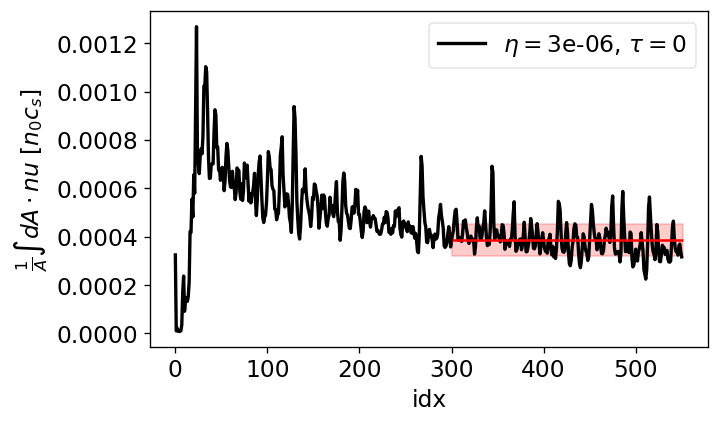

Average flux is 4.26e-04 pm 1.69e-04
Total average mass loss rate is 2110.5
Total mass gain by sources is 2516.2
particle confinement time = 2.27e+01


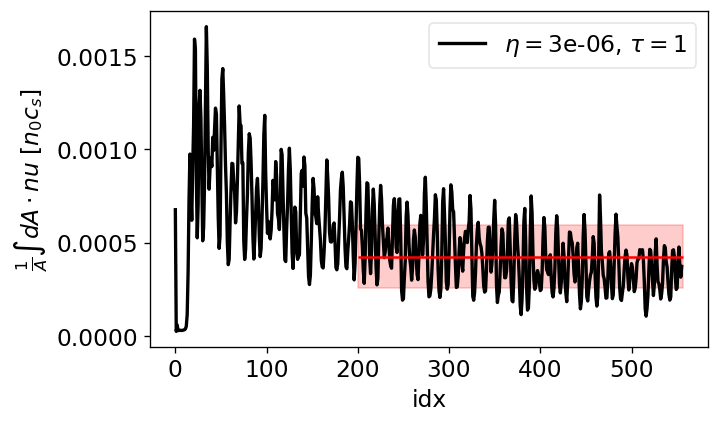

Average flux is 5.14e-04 pm 5.94e-05
Total average mass loss rate is 2548.8
Total mass gain by sources is 2935.6
particle confinement time = 2.59e+01


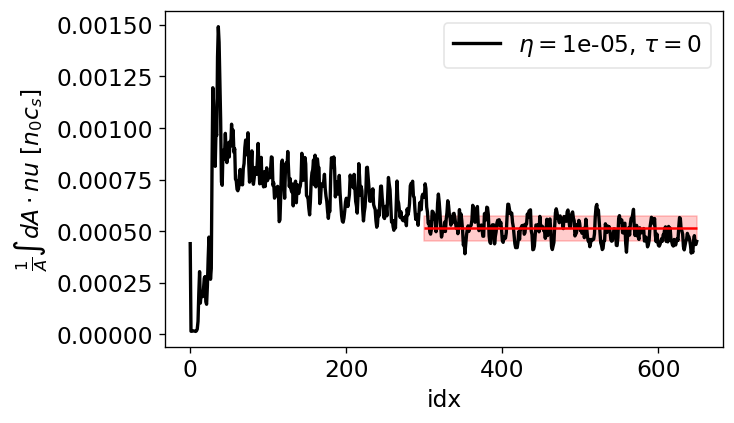

Average flux is 6.26e-04 pm 1.52e-04
Total average mass loss rate is 3102.3
Total mass gain by sources is 2935.6
particle confinement time = 2.09e+01


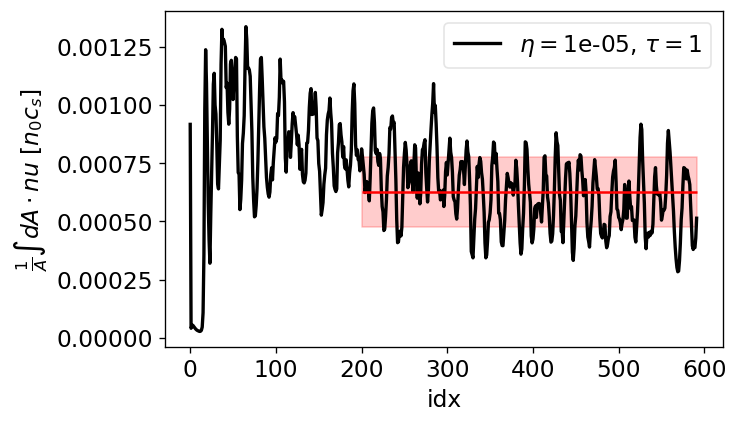

Average flux is 6.64e-04 pm 1.16e-04
Total average mass loss rate is 3290.1
Total mass gain by sources is 4193.7
particle confinement time = 2.70e+01


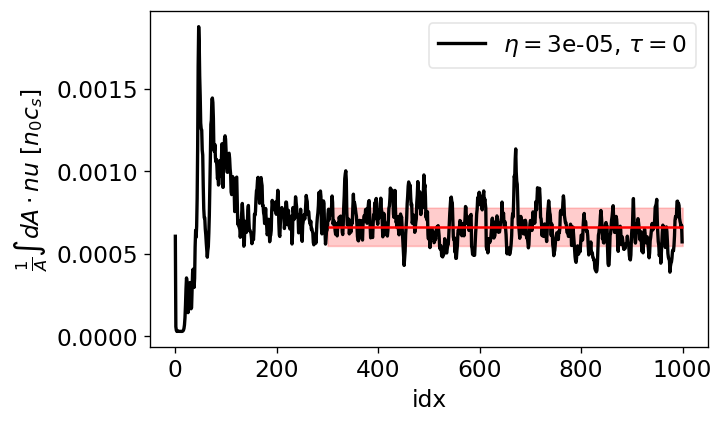

Average flux is 8.55e-04 pm 1.25e-04
Total average mass loss rate is 4238.2
Total mass gain by sources is 4193.7
particle confinement time = 2.01e+01


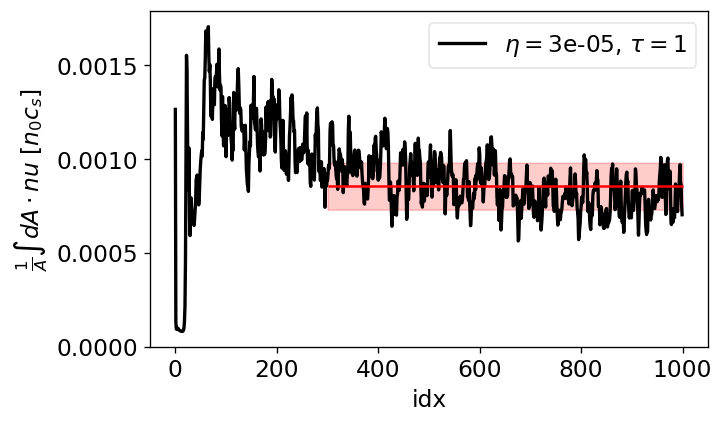

Average flux is 1.06e-03 pm 1.05e-04
Total average mass loss rate is 5243.0
Total mass gain by sources is 5871.2
particle confinement time = 2.26e+01


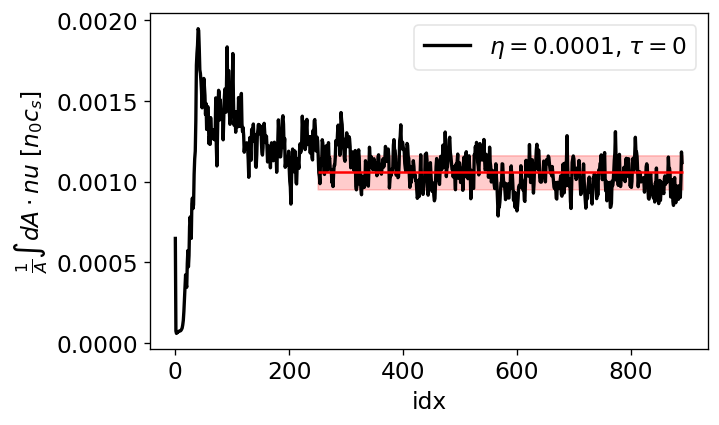

Average flux is 1.62e-03 pm 1.74e-04
Total average mass loss rate is 8014.0
Total mass gain by sources is 8387.4
particle confinement time = 1.48e+01


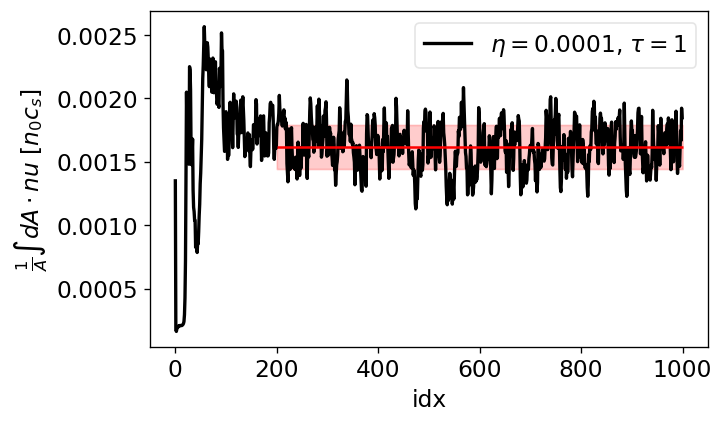

Average flux is 2.36e-03 pm 2.11e-04
Total average mass loss rate is 11705.3
Total mass gain by sources is 13419.8
particle confinement time = 1.40e+01


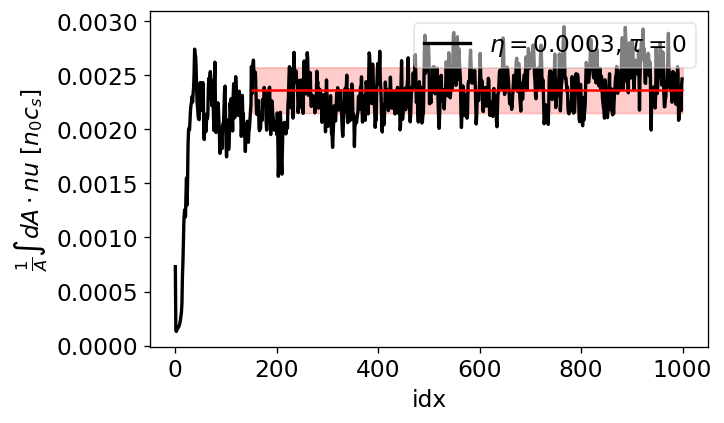

Average flux is 3.15e-03 pm 3.70e-04
Total average mass loss rate is 15612.4
Total mass gain by sources is 16774.8
particle confinement time = 1.05e+01


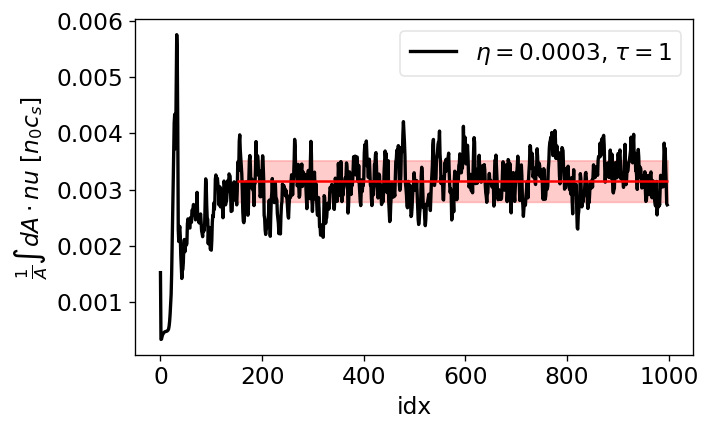

In [10]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')

    da = pp['file']

#     with open( "test-file.json","w") as f:
#         f.write(da.inputfile)
    
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne=np.asarray(da['divcurvne_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['divcurvkappane_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['divneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['divneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    #### Fill in parameters list #####
    pp['physical']['average_mass_flux_lcfs'] = average_jvne
    pp['physical']['average_mass_ifs'] = average_mass
    pp['physical']['sigma_mass_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_mass_ifs'] = sigma_mass
    ###################################
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print( f"Average flux is { average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    tau = mass/jvne
    indices = range(min_idx,np.size(time))
#     plt.plot(time[1:]*timescale,jvne[1:]/area, color='k', 
    plt.plot(jvne[1:]/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
            )
#     plt.hlines(average_jvne/area, time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.hlines(average_jvne/area, indices[0], indices[-1], color='r')
#     plt.fill_between( time[min_idx:]*timescale,
    plt.fill_between( indices,
                     (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
#     plt.xlabel(r"$t\ /\ $ms")
    plt.xlabel(r"idx")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'new-mass-flux.png',bbox_inches='tight')
    plt.show(   )


In [11]:
# ### PLOT OF TOTAL MASS CONTAINED WITHIN SEPARATRIX
# for pp in content :
#     fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
#     da = pp['file']
#     time = np.asarray(da['time'][:])
    
# #     print( pp["physical"])
# #     timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
# #     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
#     fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
#     mass =np.asarray(da['electrons_ifs_lcfs'][:])

#     plt.plot(time[1:]*timescale,mass[1:], color='k', 
#              marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
#              label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}'
#             )

#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
#     da.close()
    
#     plt.xlabel(r"$t\ [c_s/R_0]$")
#     plt.ylabel(r"$\int dV n\ [n_0\rho_s^3]$")

#     plt.show(   )

## Energy conservation

0.11553234899971436
Average flux is 1.16e-01 pm 1.56e-02
Total average energy loss rate is 572764.0
Total energy gain by sources is 6797.1
Energy confinement time = 1.13e-01


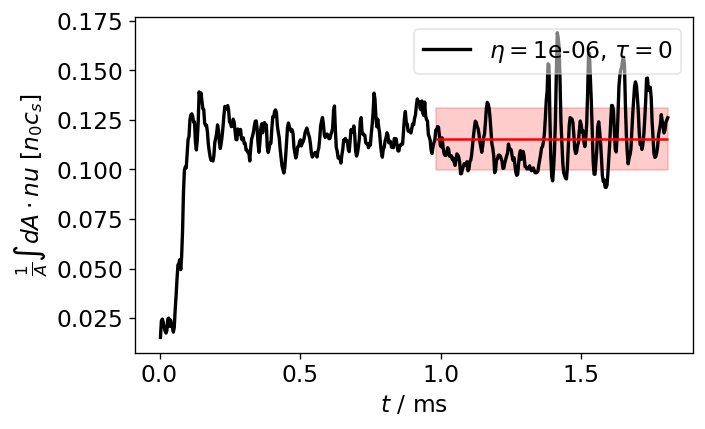

0.3101380027548702
Average flux is 3.10e-01 pm 4.49e-02
Total average energy loss rate is 1537542.3
Total energy gain by sources is 13444.0
Energy confinement time = 8.21e-02


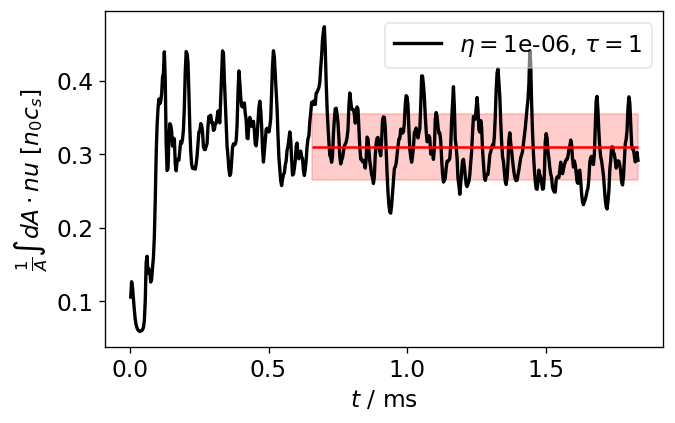

0.12484889831735398
Average flux is 1.25e-01 pm 9.03e-03
Total average energy loss rate is 618951.7
Total energy gain by sources is 8218.0
Energy confinement time = 1.40e-01


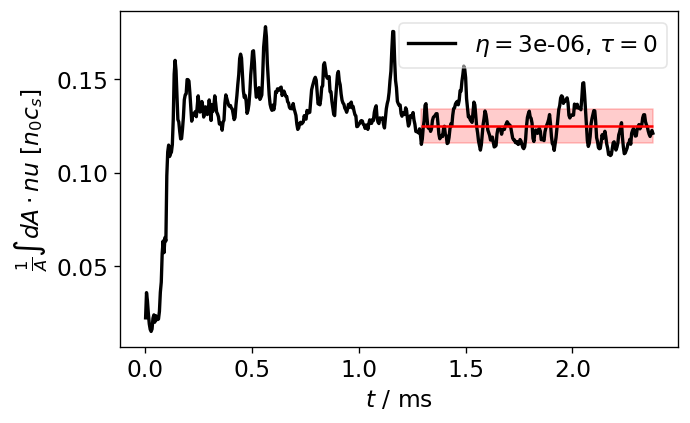

0.35078126974927043
Average flux is 3.51e-01 pm 4.12e-02
Total average energy loss rate is 1739035.6
Total energy gain by sources is 16271.5
Energy confinement time = 9.66e-02


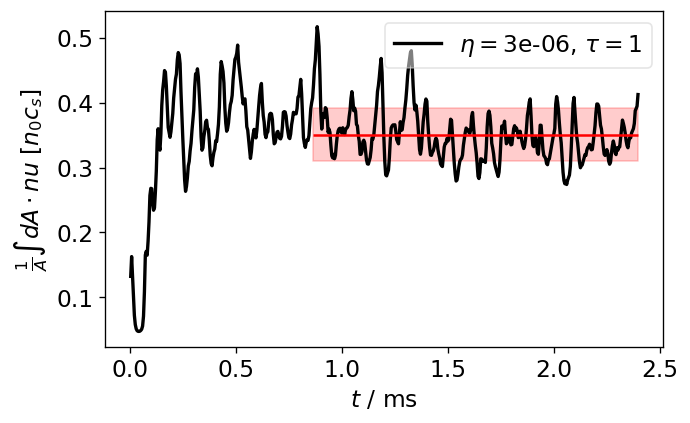

0.12984371283415688
Average flux is 1.30e-01 pm 6.64e-03
Total average energy loss rate is 643714.1
Total energy gain by sources is 9541.4
Energy confinement time = 1.78e-01


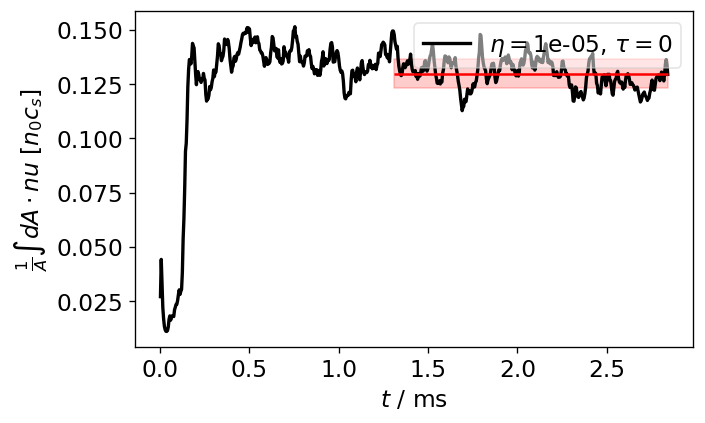

0.3388370857049489
Average flux is 3.39e-01 pm 3.57e-02
Total average energy loss rate is 1679821.0
Total energy gain by sources is 18844.4
Energy confinement time = 1.33e-01


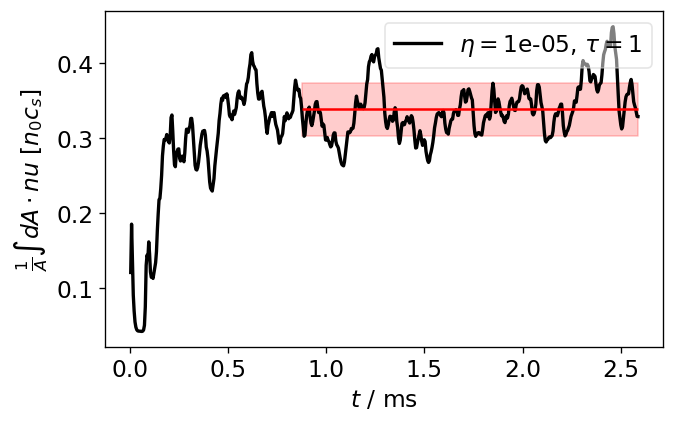

0.12840146188826038
Average flux is 1.28e-01 pm 1.25e-02
Total average energy loss rate is 636564.0
Total energy gain by sources is 13738.7
Energy confinement time = 2.45e-01


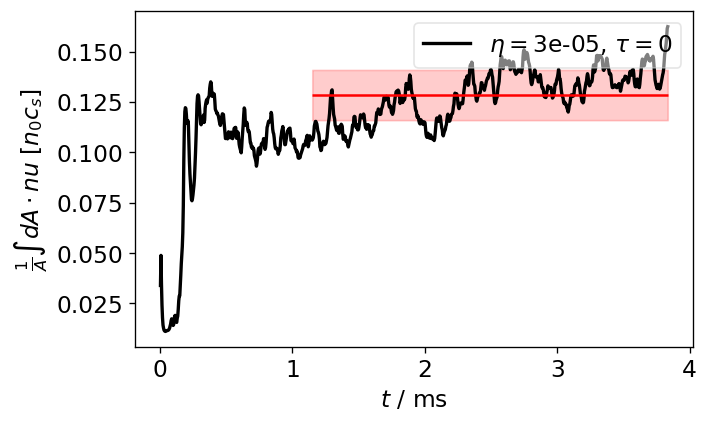

0.3455330037541556
Average flux is 3.46e-01 pm 2.08e-02
Total average energy loss rate is 1713016.7
Total energy gain by sources is 27082.0
Energy confinement time = 1.72e-01


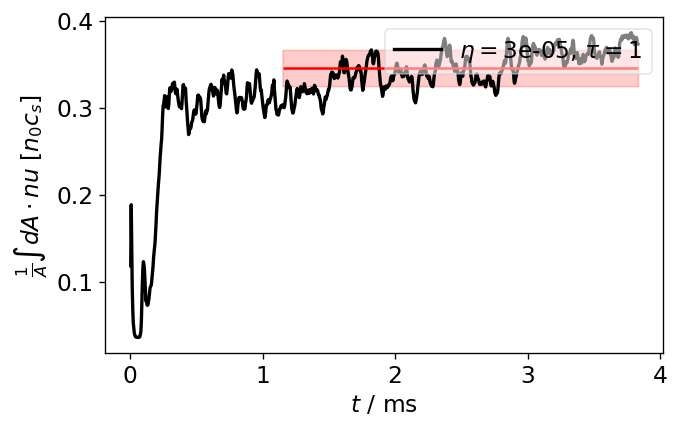

0.23063537289739405
Average flux is 2.31e-01 pm 1.38e-02
Total average energy loss rate is 1143399.5
Total energy gain by sources is 18832.5
Energy confinement time = 1.77e-01


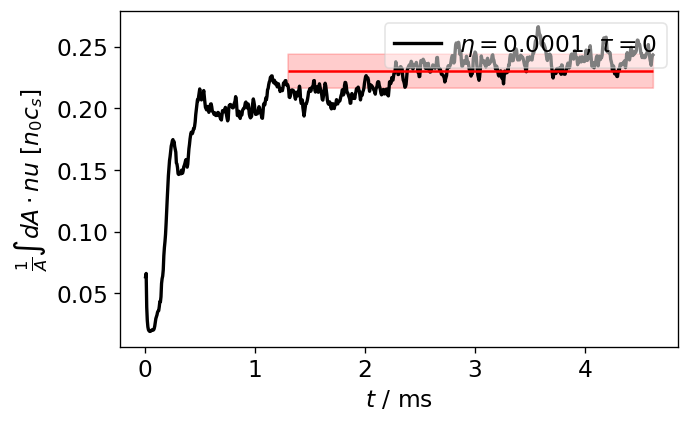

0.6722549826309776
Average flux is 6.72e-01 pm 3.78e-02
Total average energy loss rate is 3332775.8
Total energy gain by sources is 53546.0
Energy confinement time = 1.21e-01


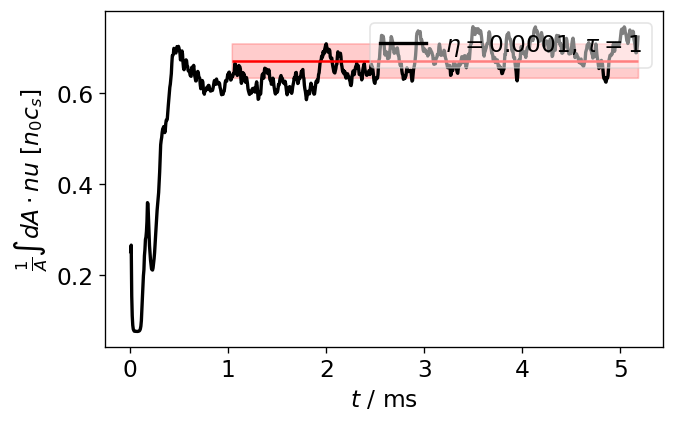

0.4643927956413963
Average flux is 4.64e-01 pm 1.87e-02
Total average energy loss rate is 2302276.8
Total energy gain by sources is 42776.6
Energy confinement time = 1.22e-01


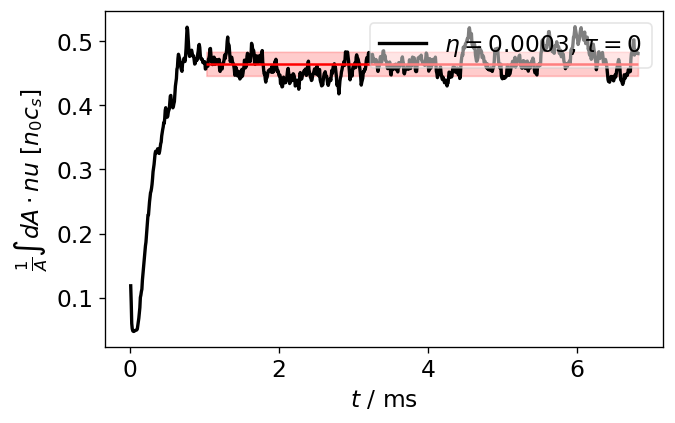

1.1374373377619382
Average flux is 1.14e+00 pm 5.83e-02
Total average energy loss rate is 5638967.0
Total energy gain by sources is 105976.6
Energy confinement time = 9.91e-02


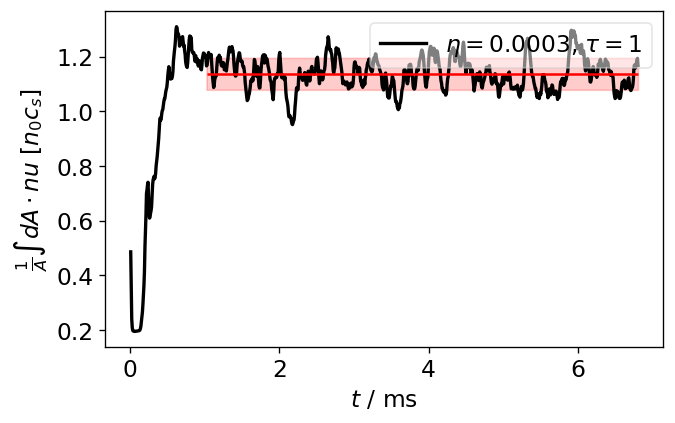

In [12]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    
    da = pp['file']
 
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)

    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

#     print( pp["physical"])
    timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = np.asarray(da['jvee_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da['jvei_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da['jveea_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(da['jveia_tt_ifs_lcfs'][:])/deltat
    
    loss = np.asarray( da['leeperp_tt_ifs_lcfs'])
    loss+= np.asarray( da['leiperp_tt_ifs_lcfs'])
    loss+= np.asarray( da['leeparallel_tt_ifs_lcfs'])
    loss+= np.asarray( da['leiparallel_tt_ifs_lcfs'])
    loss+= np.asarray( da['resistivity_tt_ifs_lcfs'])

    average_mass = np.mean(mass[min_idx:])
    sigma_mass = mass[min_idx:].std()
    average_jvne = np.mean(jvne[min_idx:]-loss[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = (jvne[min_idx:]-loss[min_idx:]).std()
    #### Fill in parameters list #####
    pp['physical']['average_energy_flux_lcfs'] = average_jvne
    pp['physical']['average_energy_ifs'] = average_mass
    pp['physical']['sigma_energy_flux_lcfs'] = sigma_jvne
    pp['physical']['sigma_energy_ifs'] = sigma_mass
    ###################################
    source =np.asarray(da['see_tt_ifs_lcfs'][:])/deltat
    source+=np.asarray(da['sei_tt_ifs_lcfs'][:])/deltat
    average_source = source[min_idx:].mean()
    area = pp['area'][pp['lcfs']]
    print(average_jvne/area)
    print( f"Average flux is {average_jvne/area:1.2e} pm {sigma_jvne/area:1.2e}")
    print( f"Total average energy loss rate is {average_jvne:6.1f}")
    print( f"Total energy gain by sources is {average_source:6.1f}" )
    print( f"Energy confinement time = {average_mass/average_jvne*timescale:1.2e}")

    plt.plot(time[1:]*timescale,(jvne[1:]-loss[1:])/area, color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=r'$\eta=$'+f'{pp["physical"]["resistivity"]}, ' + r'$\tau=$'+f'{pp["physical"]["tau"]}')
    plt.hlines(average_jvne/area, time[min_idx]*timescale, time[-1]*timescale, color='r')
    plt.fill_between( time[min_idx:]*timescale, (average_jvne-sigma_jvne)/area, 
                      (average_jvne+sigma_jvne)/area, color='red', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ /\ $ms")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    if pp['physical']['tau'] == 1 and pp['physical']['resistivity'] == 1e-4:
        plt.savefig( 'new-energy-flux.png',bbox_inches='tight')
    plt.show(   )


In [13]:
resistivities = {0: [], 1: []}
confinement_times_mass = {0: [], 1: []}
confinement_errs_mass = {0: [], 1: []}
confinement_times_energy = {0: [], 1: []}
confinement_errs_energy = {0: [], 1: []}
for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    confinement_times_mass[phys['tau']].append(
        phys['average_mass_ifs']/phys['average_mass_flux_lcfs']*timescale)
 
    confinement_errs_mass[phys['tau']].append(
        np.sqrt((phys['sigma_mass_ifs']/phys['average_mass_flux_lcfs'])**2 + 
                (phys['average_mass_ifs']/phys['average_mass_flux_lcfs']**2*phys['sigma_mass_flux_lcfs'])**2)*
                timescale)
    confinement_times_energy[phys['tau']].append(
        phys['average_energy_ifs']/phys['average_energy_flux_lcfs']*timescale)
 
    confinement_errs_energy[phys['tau']].append(
        np.sqrt((phys['sigma_energy_ifs']/phys['average_energy_flux_lcfs'])**2 + 
                (phys['average_energy_ifs']/phys['average_energy_flux_lcfs']**2*phys['sigma_energy_flux_lcfs'])**2)*
                timescale)
    print( phys['tau'], phys['resistivity'], phys['average_mass_ifs']*1e10/1e19,
              phys['average_mass_flux_lcfs']/timescale,
              phys['average_energy_ifs']*1e10/1e19)
    
# models = {0: [], 1: []}
# lin_res = np.arange( 1e-6, 3e-4, 1e-6)
# for res in lin_res:
#     if res > 3e-5: 
#         models[0].append(
#             np.sqrt(2)*0.12*(res/1e-4)**(-1/3)
#         )
#     else:
#         models[0].append(
#             np.sqrt(2)*0.18*(res/3e-5)**(1/4))
#     if res > 3e-5: 
#         models[1].append(
#             0.12*(res/1e-4)**(-1/3)
#         )
#     else:
#         models[1].append(
#             0.18*(res/3e-5)**(1/4))
# print(0.12*(3e-5/1e-4)**(-1/3))


0 1e-06 2.2687621603957617 111375211.82890646 3.960870410579083
1 1e-06 2.2156114984407593 112416316.63554665 7.70968540893717
0 3e-06 2.28892185761383 88946614.60052994 4.017104535158061
1 3e-06 2.2236275326372303 97889994.79624437 7.792173781128802
0 1e-05 2.2674352811247838 87491475.2213431 3.9348001503837438
1 1e-05 2.2204757599785325 106492023.7696962 7.661330472836624
0 3e-05 2.3154876671130515 85813837.4543143 4.0723223906589405
1 3e-05 2.2260162798686505 110542705.64653808 7.665563505210322
0 0.0001 2.2837876819648883 101206254.52407119 3.9109506158167058
1 0.0001 2.283584903952497 154696586.2838592 7.775411617284375
0 0.0003 2.401097752387086 171684711.58686844 4.123347277819293
1 0.0003 2.3994362825590407 228991896.86184406 8.193605913205943


In [14]:
from scipy.optimize import curve_fit

In [15]:
def optimizeE(eta, a, b):
    return np.where( eta < (b/a)**(12/7) , a*eta**(1/4), b*eta**(-1/3))
def optimizeM(eta, a, b):
    return np.where( eta < (b/a)**(3) , a, b*eta**(-1/3))

In [16]:
res = resistivities[0]+ resistivities[1]

valsM = confinement_times_mass[0]+ confinement_times_mass[1]
valsE = confinement_times_energy[0]+ confinement_times_energy[1]
for i in range(6):
    valsM[i] = valsM[i]/np.sqrt(2)
    valsE[i] = valsE[i]/np.sqrt(2)
poptM, pcov = curve_fit( optimizeM, res, valsM, p0 = (2.3, 0.006))
poptE, pcov = curve_fit( optimizeE, res, valsE, p0 = (2.3, 0.006))
print(poptM, poptE)

[19.17730134  0.70278324] [2.34596736 0.00587293]


Transition at eta =  4.921547896986017e-05


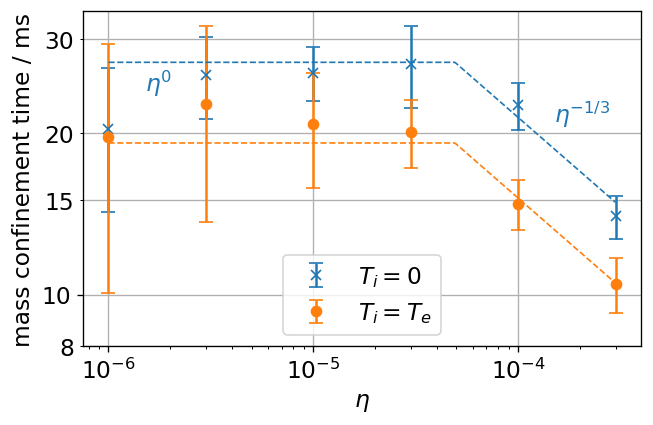

In [17]:
models = {0: [], 1: []}
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    models[0].append( optimizeM( res, *poptM)*np.sqrt(2))
    models[1].append( optimizeM( res, *poptM))
# MANUAL FIT
#     if res > (14/20)**3*1e-4: 
#         models[0].append(
#             np.sqrt(2)*14*(res/1e-4)**(-0.33)
#         )
#     else:
#         models[0].append(20*np.sqrt(2))
#     if res > (14/20)**3*1e-4: 
#         models[1].append(
#             14*(res/1e-4)**(-0.33)
#         )
#     else:
#         models[1].append(20)
print( "Transition at eta = ", (poptM[1]/poptM[0])**3 )
##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times_mass[0],
             yerr=confinement_errs_mass[0], marker='x', ls='',label=r'$T_i=0$',
            color = 'C0',capsize=4)
ax.errorbar( resistivities[1], confinement_times_mass[1],
             yerr=confinement_errs_mass[1], marker='o', ls='',label=r'$T_i=T_e$',
            color = 'C1',capsize=4)
ax.plot( lin_res, models[0], ls='--', lw = 1, color = 'C0')
ax.plot( lin_res, models[1], ls='--', lw = 1, color = 'C1')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('mass confinement time / ms')
# Rewrite the y labels
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
ax.set_yticks( [8, 15, 20,30], minor = True)
ax.grid(which='both',axis='y')
ax.grid(axis='x')

plt.text(1.5e-6, 24, '$\eta^{0}$', c='C0')
plt.text(1.5e-4, 21, '$\eta^{-1/3}$', c='C0')
plt.legend(loc='lower center')
plt.savefig('new-mass_confinement_time.png',bbox_inches='tight')
plt.show()

Transition at eta =  3.470099381033644e-05


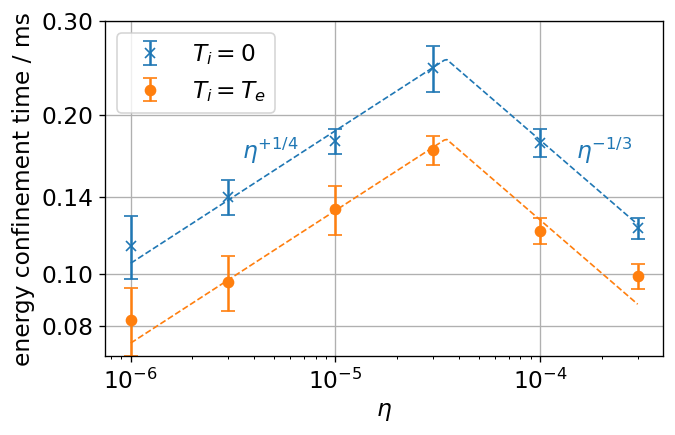

In [18]:
models = {0: [], 1: []}
lin_res = np.arange( 1e-6, 3e-4, 1e-6)
for res in lin_res:
    models[0].append( optimizeE( res, *poptE)*np.sqrt(2))
    models[1].append( optimizeE( res, *poptE))
# MANUAL FIT
#     if res > 3.4e-5: 
#         models[0].append(
#             np.sqrt(2)*0.18*(res/3e-5)**(-1/3)
#         )
#     else:
#         models[0].append(
#             np.sqrt(2)*0.18*(res/3e-5)**(1/4))
#     if res > 3.4e-5: 
#         models[1].append(
#             0.18*(res/3e-5)**(-1/3)
#         )
#     else:
#         models[1].append(
#             0.18*(res/3e-5)**(1/4))
print( "Transition at eta = ", (poptE[1]/poptE[0])**(12/7) )
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
ax.errorbar( resistivities[0], confinement_times_energy[0],
             yerr=confinement_errs_energy[0], marker='x', ls='',label=r'$T_i=0$',
            color = 'C0',capsize=4)
ax.errorbar( resistivities[1], confinement_times_energy[1],
             yerr=confinement_errs_energy[1], marker='o', ls='',label=r'$T_i=T_e$',
            color = 'C1',capsize=4)
ax.plot( lin_res, models[0], ls='--', lw = 1, color = 'C0')
ax.plot( lin_res, models[1], ls='--', lw = 1, color = 'C1')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('energy confinement time / ms')
# Rewrite the y labels
ax.set_ylim([0.07,0.3])
ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.2f}'))
ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.2f}'))
ax.set_yticks( [0.08, 0.1, 0.14,0.2,0.3])
ax.grid()
ax.set_yticks([],minor=True)
plt.text(1.5e-4, 0.165, '$\eta^{-1/3}$', c='C0')
plt.text(3.5e-6, 0.165, '$\eta^{+1/4}$', c='C0')
plt.legend()
plt.savefig('new-energy_confinement_time.png',bbox_inches='tight')
plt.show()

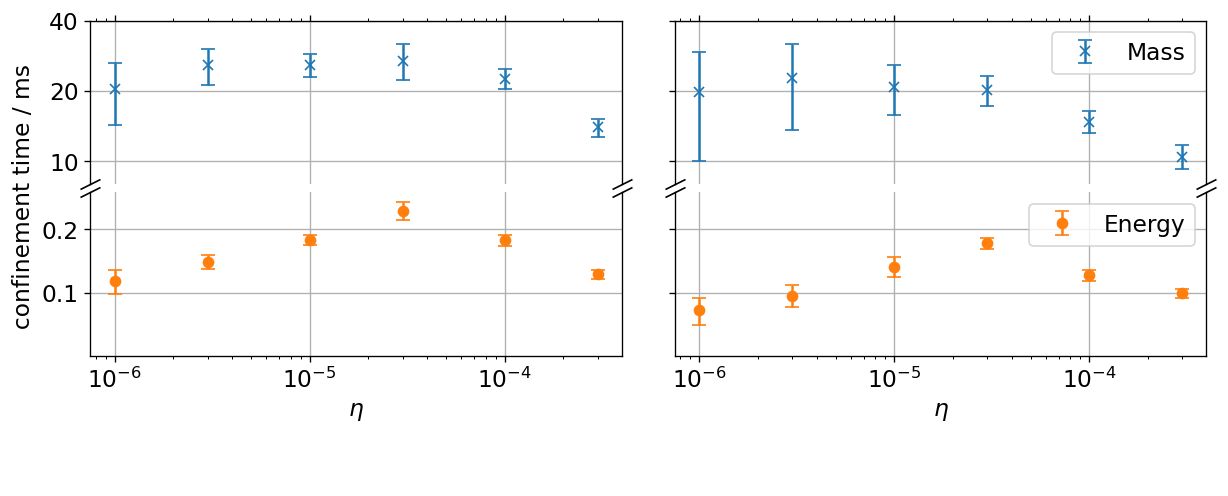

In [19]:
##########################
fig,axs=plt.subplots(2,2, sharex = "row", figsize=(2*6,3.7), dpi= 120, facecolor='w', edgecolor='k',
    gridspec_kw = {'wspace':0.1, 'hspace':0.05})
# https://stackoverflow.com/questions/20057260/how-to-remove-gaps-between-subplots-in-matplotlib
for tau in [0,1]:
    axs[0][tau].errorbar( resistivities[tau], confinement_times_mass[tau],
             yerr=confinement_errs_mass[tau], marker='x', ls='',label=r'Mass'
            ,capsize=4, color = 'C0')
    axs[1][tau].errorbar( resistivities[tau], confinement_times_energy[tau],
             yerr=confinement_errs_energy[tau], marker='o', ls='',label=r'Energy'
            ,capsize=4, color = 'C1')
#     axs[tau].set_ylim([0,0.3])
    axs[0][tau].grid()
    axs[1][tau].grid()
    axs[0][tau].set_xscale('log')
    axs[1][tau].set_xscale('log')
    axs[0][tau].set_yscale('log')
    axs[1][tau].set_yscale('log')
    axs[1][tau].set_xlabel(r'$\eta$')
# Broken axis example
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html    
    
    # hide the spines between ax and ax2
    axs[0][tau].spines.bottom.set_visible(False)
    axs[1][tau].spines.top.set_visible(False)
    axs[0][tau].xaxis.tick_top()
    axs[0][tau].tick_params(labeltop=False)  # don't put tick labels at the top
    axs[1][tau].xaxis.tick_bottom()
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axs[0][tau].plot([0, 1], [0, 0], transform=axs[0][tau].transAxes, **kwargs)
    axs[1][tau].plot([0, 1], [1, 1], transform=axs[1][tau].transAxes, **kwargs)

axs[0][1].legend(loc = 'upper right')
axs[1][1].legend(loc = 'upper right')
# tau = 1 no y labels
axs[0][0].set_ylim([8,40])
axs[0][1].set_ylim([8,40])
axs[1][0].set_ylim([0.05,0.3])
axs[1][1].set_ylim([0.05,0.3])
axs[0][0].set_yticks([10,20,40], labels=["10","20","40"])
axs[0][1].set_yticks([10,20,40])
axs[1][0].set_yticks([0.1,0.2], labels=["0.1","0.2"])
axs[1][1].set_yticks([0.1,0.2])
axs[0][0].set_yticks([],minor=True)
axs[0][1].set_yticks([],minor=True)
axs[1][0].set_yticks([],minor=True)
axs[1][1].set_yticks([],minor=True)

# axs[0][0].set_yticks([1,1.0,1.5])
# axs[0][0].set_yticks([1,2,3])
# axs[1][0].set_yticks([0.1,0.2])
# axs[1][0].set_yticks([],minor=True)
axs[0][1].tick_params(labelleft=False)  
axs[1][1].tick_params(labelleft=False)   
# axs[1][1].set_yticklabels([])
axs[1][0].set_ylabel('                     confinement time / ms')
# axs[0][1].yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.1f}'))
# plt.savefig( 'new-ne-importance-'+str(tau)+'.png',bbox_inches='tight')
plt.savefig( 'new-confinement-time.png',bbox_inches='tight')
# plt.savefig('new-energy_confinement_time.png',bbox_inches='tight')
plt.show()


Let's be careful with too general conclusions about the two regimes. The equations are fairly basic with isothermal assumption. There could still be hidden systematic numerical issues (e.g. turbulence in low resistivity does not reach core region?)

### Average FSA Mass conservation 

Resistivity = 1e-06 tau = 0
Average diff =  -93.94446607424504
Average std  =  39.79308497982958


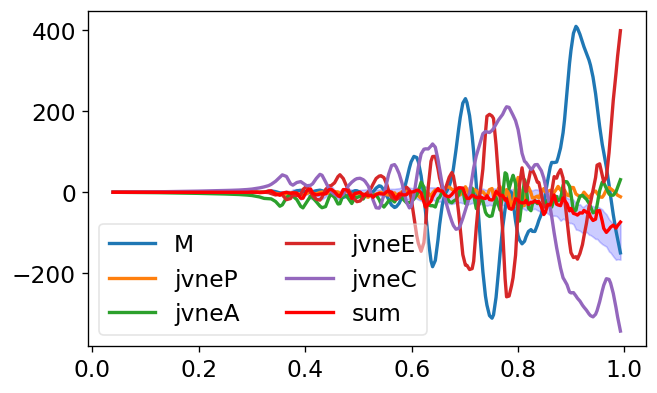

Resistivity = 1e-06 tau = 1
Average diff =  -15.555023495519826
Average std  =  23.86235447143608


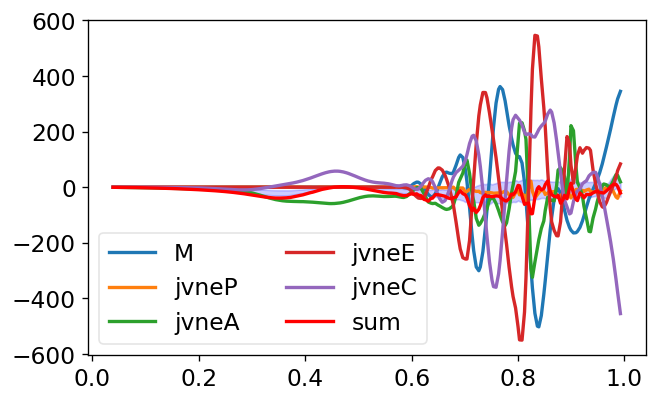

Resistivity = 3e-06 tau = 0
Average diff =  -76.10992048212026
Average std  =  24.170563858999692


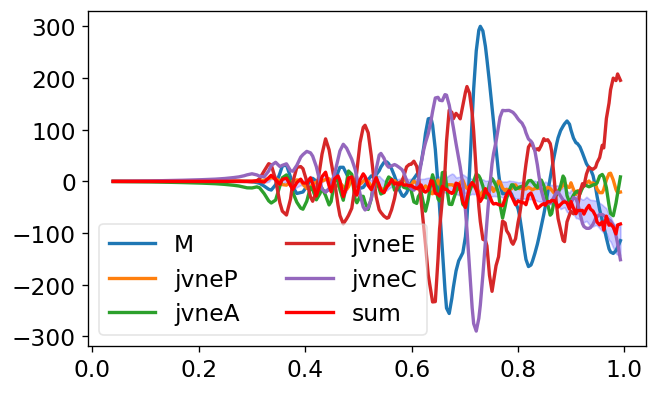

Resistivity = 3e-06 tau = 1
Average diff =  -39.27284428029107
Average std  =  22.398442349590756


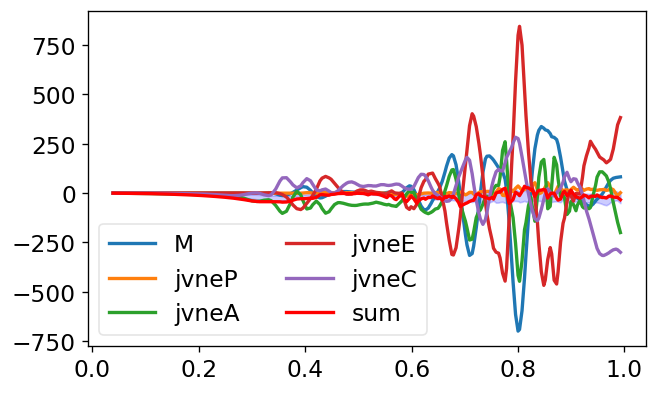

Resistivity = 1e-05 tau = 0
Average diff =  -86.11634866336277
Average std  =  25.67180176037428


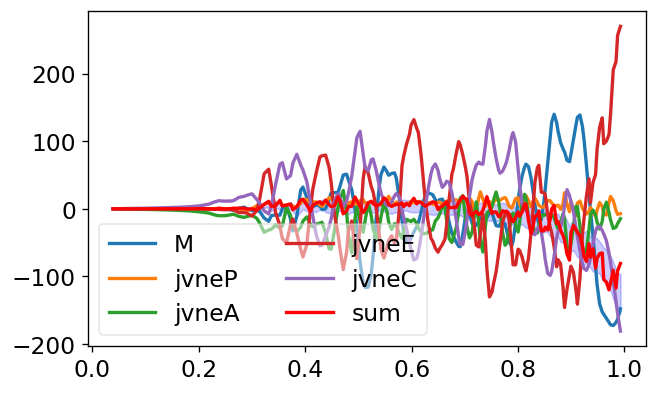

Resistivity = 1e-05 tau = 1
Average diff =  -9.10891351069233
Average std  =  19.664208865292068


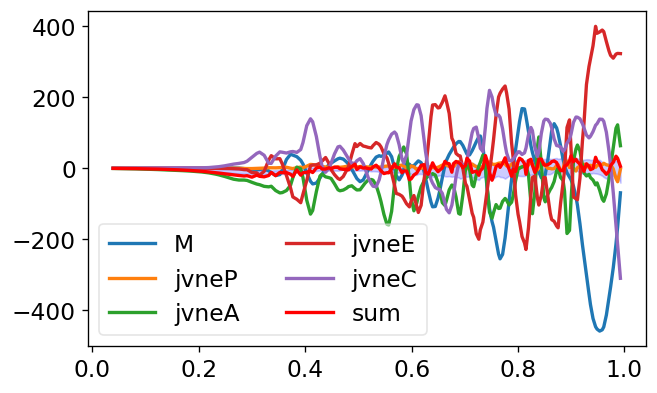

Resistivity = 3e-05 tau = 0
Average diff =  -28.970269168729182
Average std  =  21.239765629667435


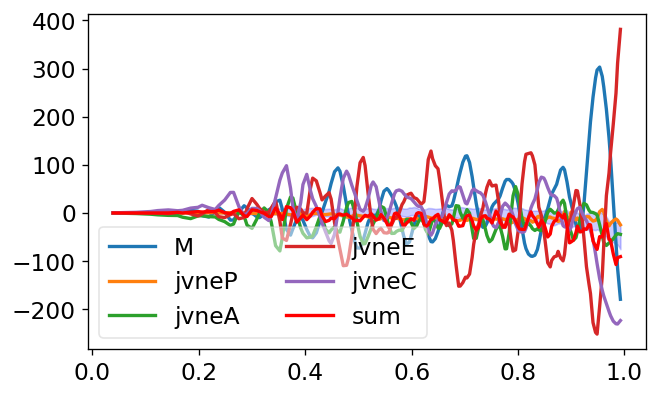

Resistivity = 3e-05 tau = 1
Average diff =  -12.110782707436318
Average std  =  26.273641479701666


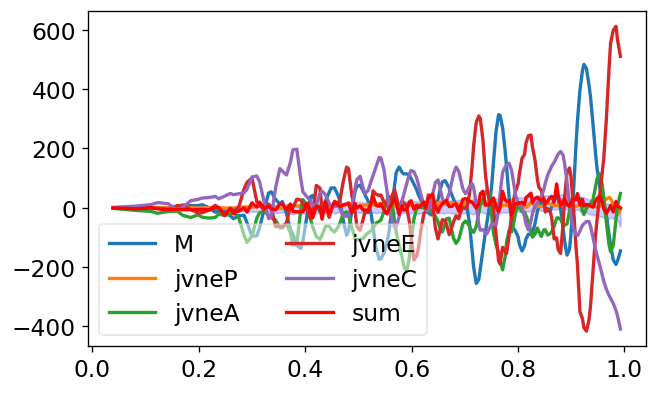

Resistivity = 0.0001 tau = 0
Average diff =  -128.11667805566745
Average std  =  36.544652731084874


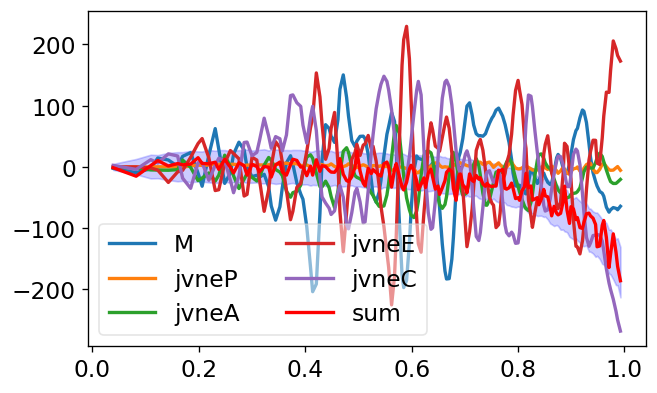

Resistivity = 0.0001 tau = 1
Average diff =  -8.821490119713602
Average std  =  54.6888118612646


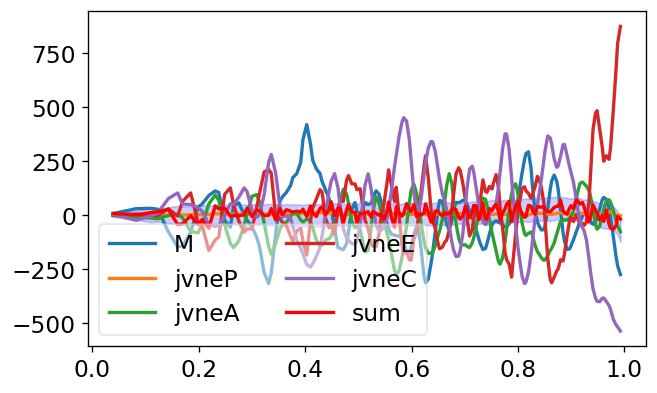

Resistivity = 0.0003 tau = 0
Average diff =  -128.97847652330805
Average std  =  92.14101148223288


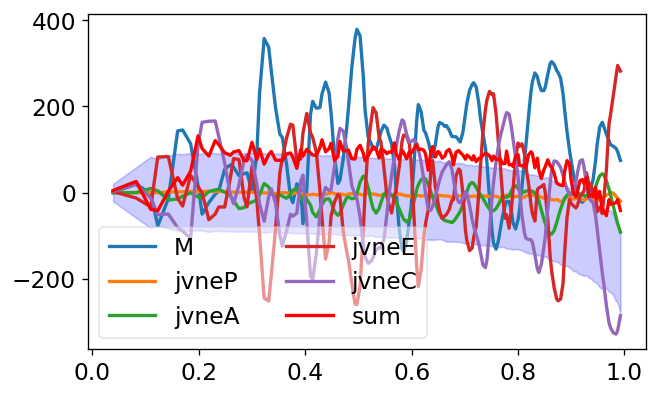

Resistivity = 0.0003 tau = 1
Average diff =  -33.07312703212589
Average std  =  91.38413151687078


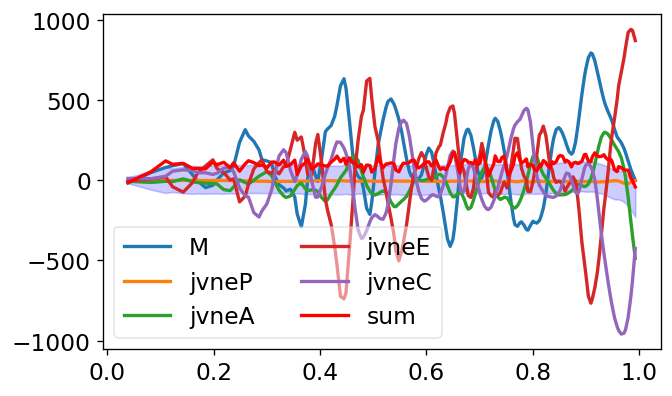

In [20]:

for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']

    mass =np.asarray(da['electrons_ifs'][:,:]-da['ions_ifs'][:,:])
    time = np.asarray(da['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(pp['rho']))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    jvneC=np.asarray(da['jvcurvne_tt_fsa'][:,:]-da['jvcurvni_tt_fsa'][:,:])/deltat[:,None]
    jvneE=np.asarray(da['jvneE_tt_fsa'][:,:]-da['jvniE_tt_fsa'][:,:])/deltat[:,None]
    jvneA=np.asarray(da['jvneA_tt_fsa'][:,:]-da['jvniA_tt_fsa'][:,:])/deltat[:,None]
    jvneP=np.asarray(da['divjnepar_tt_ifs'][:,:]-da['divjnipar_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA+jvneP
    
#     diff_perp = np.asarray(da["lneperp_tt_fsa"][:,:])/deltat[:,None]
#     diff_parallel = np.asarray(da["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne#-diff_perp-diff_parallel
    diff = (deltamass + rhs)
   
    average_diff = np.mean( diff[min_idx:], axis=0)
    average_std =  np.std( diff[min_idx:], axis=0)
    idx=160
    print(f'Resistivity = {pp["physical"]["resistivity"]} tau = {pp["physical"]["tau"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot( pp['rho_t'][0:167], deltamass[-1,0:167], ls = '-', lw = 2, label = 'M')
    plt.plot( pp['rho_t'][0:167], jvneP[-1,0:167], ls = '-', lw = 2, label = 'jvneP')
    plt.plot( pp['rho_t'][0:167], jvneA[-1,0:167], ls = '-', lw = 2, label = 'jvneA')
    plt.plot( pp['rho_t'][0:167], jvneE[-1,0:167], ls = '-', lw = 2, label = 'jvneE')
    plt.plot( pp['rho_t'][0:167], jvneC[-1,0:167], ls = '-', lw = 2, label = 'jvneC')
    plt.plot( pp['rho_t'][0:167], diff[-1,0:167], ls = '-', color='r', lw = 2, label = 'sum')
    plt.fill_between( pp['rho_t'][0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    plt.show()

### Density profile

In [21]:
cmap = plt.get_cmap( "viridis_r") # magma, inferno
cmp = [0,0,0,0,0,0]
norm = colors.LogNorm(vmin = 1e-6, vmax = 3e-4)
i = 0
for res in [1e-6,3e-6,1e-5,3e-5,1e-4,3e-4]:
    cmp[i] = cmap(norm(res))
    i+=1
# cmp = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404'] # oranges (colorBrewer)
# cmp = ["#21f0b6", "#0b5313", "#bae342", "#559310", "#98d5a0", "#169294"] # colorgorical
print(cmp)
res2idx = {1e-6:0, 3e-6:1, 1e-5:2, 3e-5:3,1e-4:4,3e-4:5}

[(0.993248, 0.906157, 0.143936, 1.0), (0.496615, 0.826376, 0.306377, 1.0), (0.132268, 0.655014, 0.519661, 1.0), (0.162142, 0.474838, 0.55814, 1.0), (0.257322, 0.25613, 0.526563, 1.0), (0.267004, 0.004874, 0.329415, 1.0)]


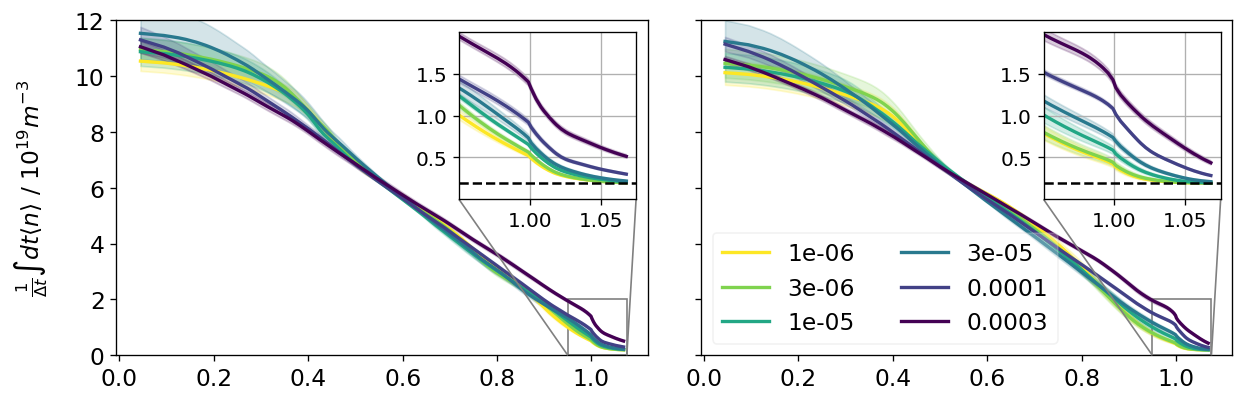

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


fig,axs=plt.subplots(1,2, figsize=(2*6,3.7), dpi= 120, facecolor='w', edgecolor='k',
    gridspec_kw = {'wspace':0.1, 'hspace':0.05})
for tau in [0,1]:
    
    for pp in content :
        res = pp["physical"]["resistivity"] 
        taui = pp["physical"]["tau"]
        if taui == tau:
            da = pp['file']


            time = np.asarray(da.variables['time'][:])
            min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
            density =da['electrons_fsa'][:]
    #         density =da['laplace_ne_fsa'][:]

            avg_density=density[min_idx:-1].mean(axis=0)
            std_density=density[min_idx:-1].std(axis=0)
            cmap = plt.get_cmap( "copper_r")
            norm = colors.LogNorm(vmin = 1e-6, vmax = 3e-4)
            axs[tau].plot( pp['rho_p'], avg_density, ls='-', lw=2, color = cmp[res2idx[res]],
                     label=f'{pp["physical"]["resistivity"]}')
            
            axs[tau].fill_between( pp['rho_p'], (avg_density-std_density), 
                              (avg_density+std_density),color = cmp[res2idx[res]], alpha=0.2)
#             handles, labels = plt.gca().get_legend_handles_labels()
#             handles, labels = plt.gca().get_legend_handles_labels()

    #     plt.xlim(0.9,1.075)
#     ax.hlines( 0.2, xmin=0, xmax =1.1, color = 'k', ls = '--')
#     ax.vlines( 0.55, ymin = -1, ymax = 20, color = 'k', ls = '--')
    axs[tau].set_ylim(0,12)
    # Plot inset axis
    axins = zoomed_inset_axes(axs[tau], 3, loc='upper right')
    for pp in content :
        res = pp["physical"]["resistivity"] 
        taui = pp["physical"]["tau"]
        if taui == tau:
            da = pp['file']
            time = np.asarray(da.variables['time'][:])
            min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
            density =da['electrons_fsa'][:]
            avg_density=density[min_idx:-1].mean(axis=0)
            std_density=density[min_idx:-1].std(axis=0)
            cmap = plt.get_cmap( "copper_r")
            norm = colors.LogNorm(vmin = 1e-6, vmax = 3e-4)

            axins.plot( pp['rho_p'], avg_density, ls='-', lw=2, color = cmp[res2idx[res]])
            axins.fill_between( pp['rho_p'], (avg_density-std_density), 
                              (avg_density+std_density),color = cmp[res2idx[res]], alpha=0.2)
    axins.set_xlim(0.95, 1.075)
    axins.xaxis.grid(which="both")
    axins.yaxis.grid(which="both")
    axins.hlines( 0.2, xmin = 0.95, xmax = 1.075, color = 'k', ls = '--')
#     plt.setp(axins.get_xticklabels(), visible=False)
#     plt.setp(axins.get_yticklabels(), visible=False)
    axins.tick_params(axis='both', which='major', labelsize=12)
    axins.set_xticks([1.0,1.05], labels=["1.00","1.05"])
    axins.set_yticks([0.5,1.0,1.5])
#     axins.xaxis.tick_top()
#     axins.yaxis.tick_right()
    mark_inset(axs[tau], axins, loc1=3, loc2=4, fc="none", ec="0.5")
    axins.set_ylim(0, 2)
#     axs[tau].tick_params(labelbottom=False)  
#     axs[tau].set_xlabel(r"$\rho_p$")
axs[1].legend(loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)

axs[0].set_ylabel(r"$\frac{1}{\Delta t}\int dt \langle n\rangle\ /\ 10^{19} m^{-3}$",
                 labelpad=15) # labelpad is to bring it in-line with fluc plot below
# axs[1].set_yticks([])
axs[1].tick_params(labelleft=False)  
plt.savefig( "ne-profiles.png", bbox_inches ="tight")
plt.show(  )

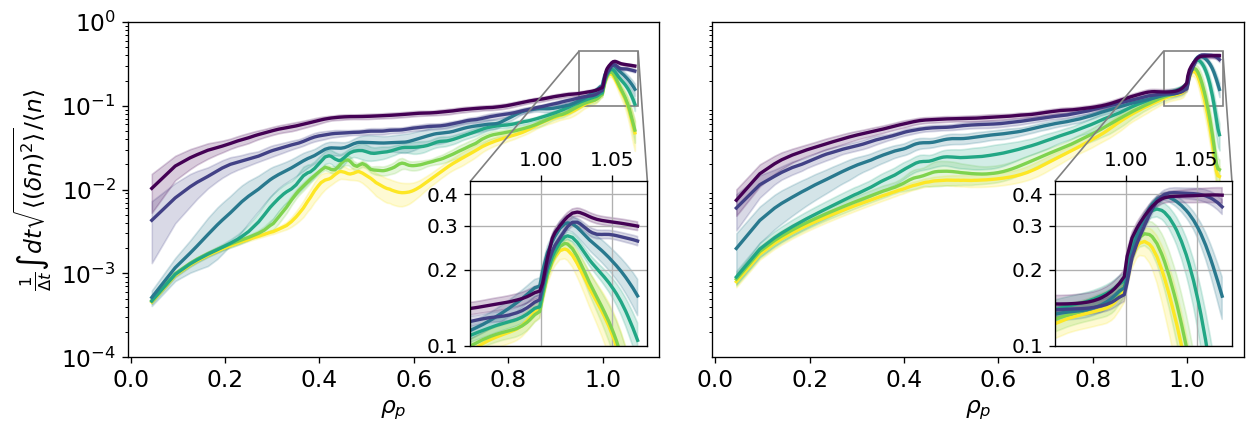

In [23]:

fig,axs=plt.subplots(1,2, figsize=(2*6,3.7), dpi= 120, facecolor='w', edgecolor='k',
    gridspec_kw = {'wspace':0.1, 'hspace':0.05})
for tau in [0,1]:
    for pp in content :
        res = pp["physical"]["resistivity"] 
        taui = pp["physical"]["tau"]
        if taui == tau:
            da = pp['file']


            time = np.asarray(da.variables['time'][:])
            min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#             density =da['electrons_std_fsa'][:]/da['electrons_fsa'][:]
            density =np.sqrt( da['ne2_fsa'][:] - da['electrons_fsa'][:]**2) /da['electrons_fsa'][:]
            avg_density=density[min_idx:-1].mean(axis=0)
            std_density=density[min_idx:-1].std(axis=0)
            axs[tau].plot( pp['rho_p'], avg_density, ls='-', lw=2, color = cmp[res2idx[res]],
                     label=f'{pp["physical"]["resistivity"]}')
            axs[tau].fill_between( pp['rho_p'], (avg_density-std_density), 
                              (avg_density+std_density),color = cmp[res2idx[res]], alpha=0.2)

    axs[tau].set_xlabel(r"$\rho_p$")
    axs[tau].set_yscale('log')
    axs[tau].set_ylim(1e-4,1)
    # Plot inset axis
    axins = zoomed_inset_axes(axs[tau], 3, loc='lower right')
    for pp in content :
        res = pp["physical"]["resistivity"] 
        taui = pp["physical"]["tau"]
        if taui == tau:
            da = pp['file']
            time = np.asarray(da.variables['time'][:])
            min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
#             density =da['electrons_std_fsa'][:]/da['electrons_fsa'][:]
            density =np.sqrt( da['ne2_fsa'][:] - da['electrons_fsa'][:]**2) /da['electrons_fsa'][:]
            avg_density=density[min_idx:-1].mean(axis=0)
            std_density=density[min_idx:-1].std(axis=0)
            cmap = plt.get_cmap( "copper_r")
            norm = colors.LogNorm(vmin = 1e-6, vmax = 3e-4)

            axins.plot( pp['rho_p'], avg_density, ls='-', lw=2, color = cmp[res2idx[res]])
            axins.fill_between( pp['rho_p'], (avg_density-std_density), 
                              (avg_density+std_density),color = cmp[res2idx[res]], alpha=0.2)
    axins.set_xlim(0.95, 1.075)
    axins.set_yscale('log')
    axins.xaxis.grid(which="both")
    axins.yaxis.grid(which="both")
    axins.tick_params(axis='both', which='major', labelsize=12)
#     plt.setp(axins.get_xticklabels(), visible=False)
#     plt.setp(axins.get_yticklabels(), visible=False)
    axins.set_xticks([1.0,1.05], labels=["1.00","1.05"])
    axins.set_yticks([0.1,0.2,0.3,0.4], labels=["0.1","0.2","0.3","0.4"])
    axins.xaxis.tick_top()
    mark_inset(axs[tau], axins, loc1=2, loc2=1, fc="none", ec="0.5")
    
    axins.set_ylim(0.1, 0.45)

axs[1].set_yticks([])
axs[0].set_ylabel(r"$\frac{1}{\Delta t}\int dt \sqrt{\langle (\delta n)^2\rangle} / \langle n\rangle$")
# axs[0].legend(loc='upper left',numpoints=1,ncol=2,
#            fontsize='medium',framealpha=0.25)
plt.savefig( "ne-fluc-profiles.png", bbox_inches ="tight")
plt.show(  )

## Ion toroidal momentum plot

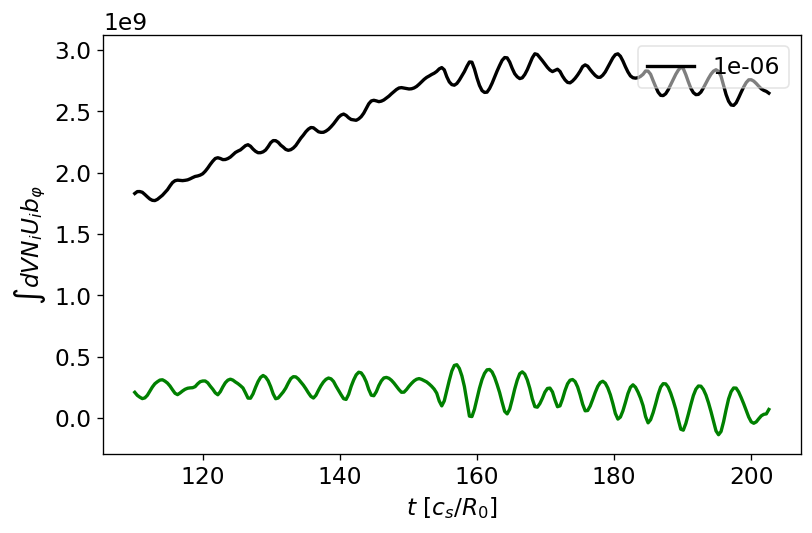

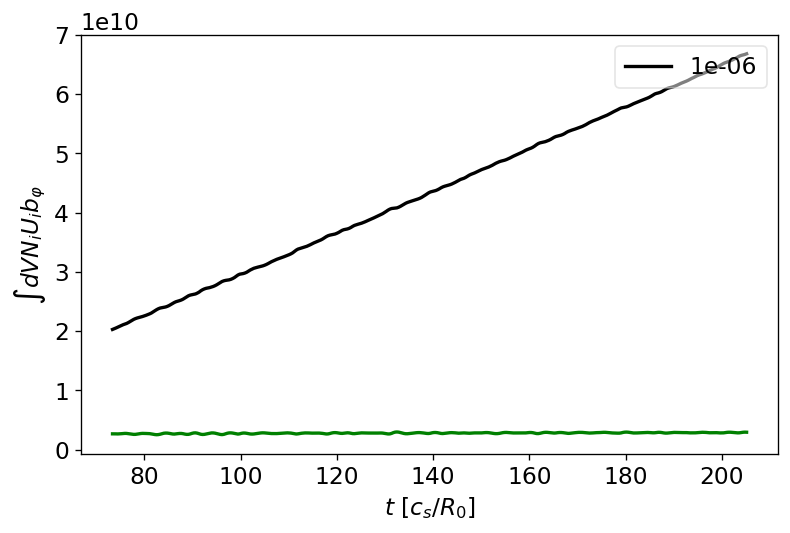

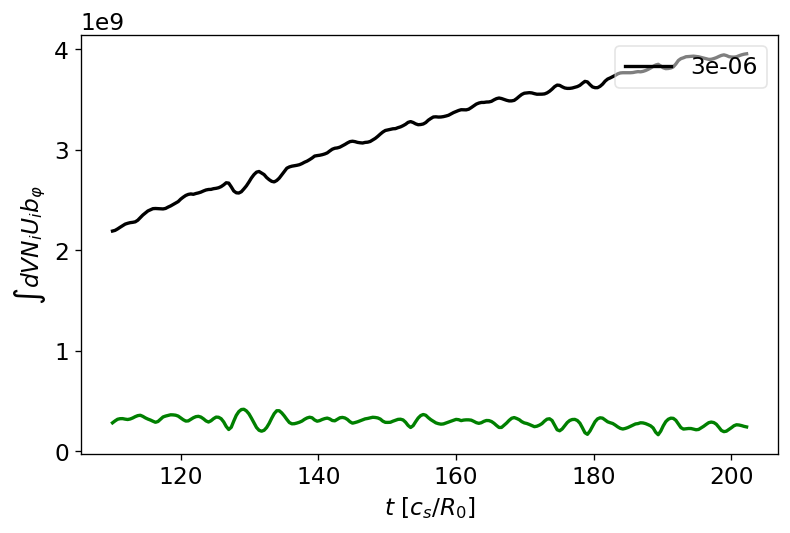

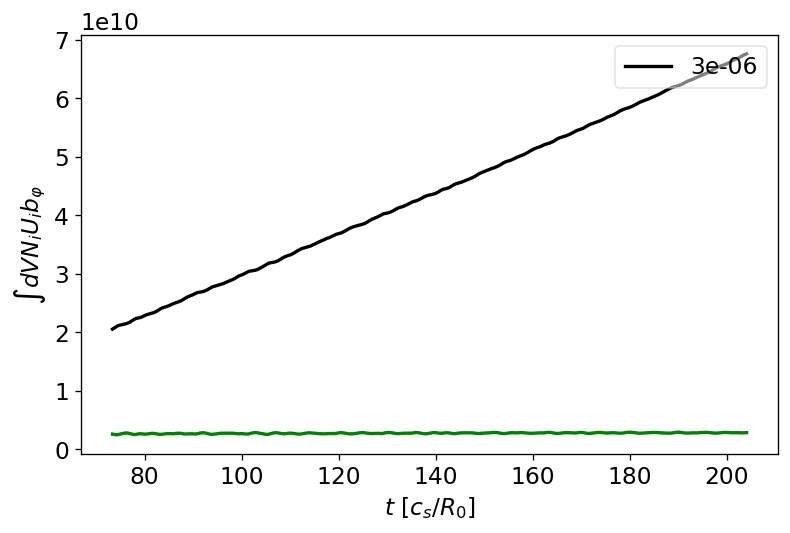

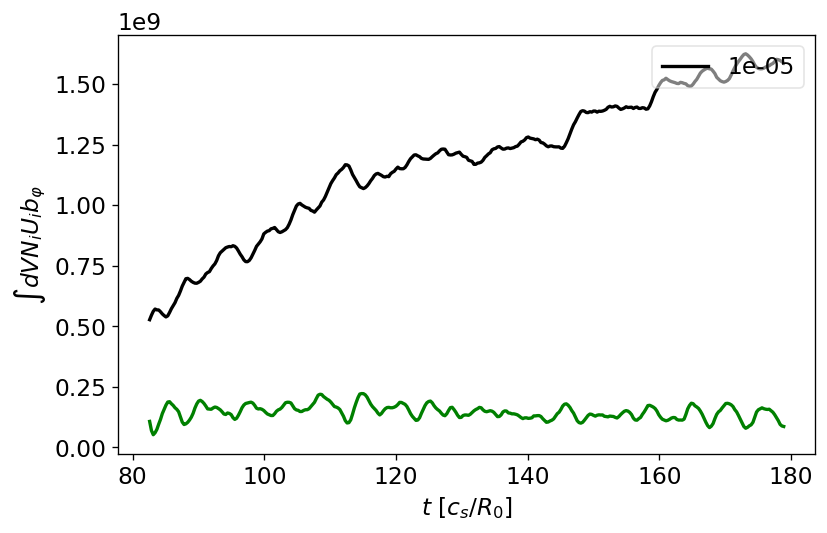

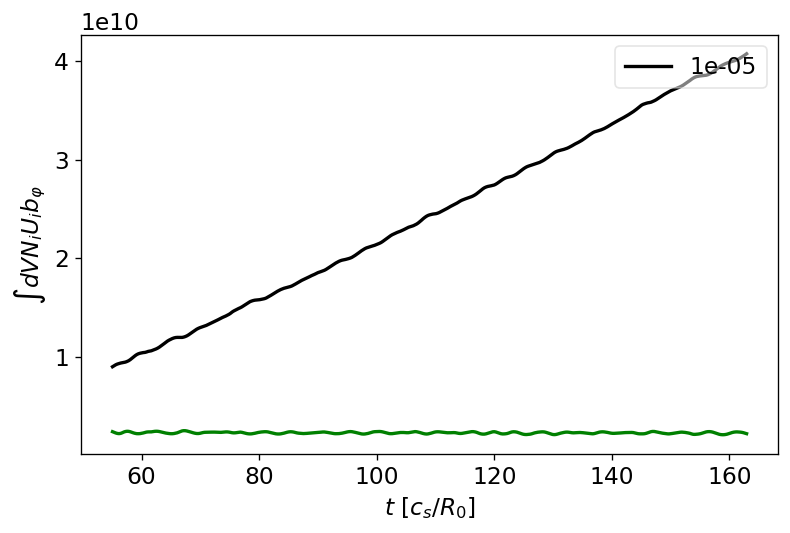

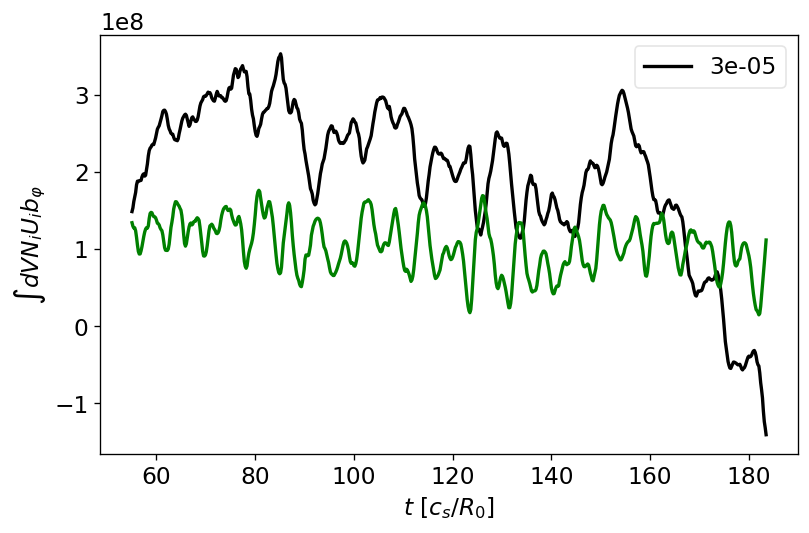

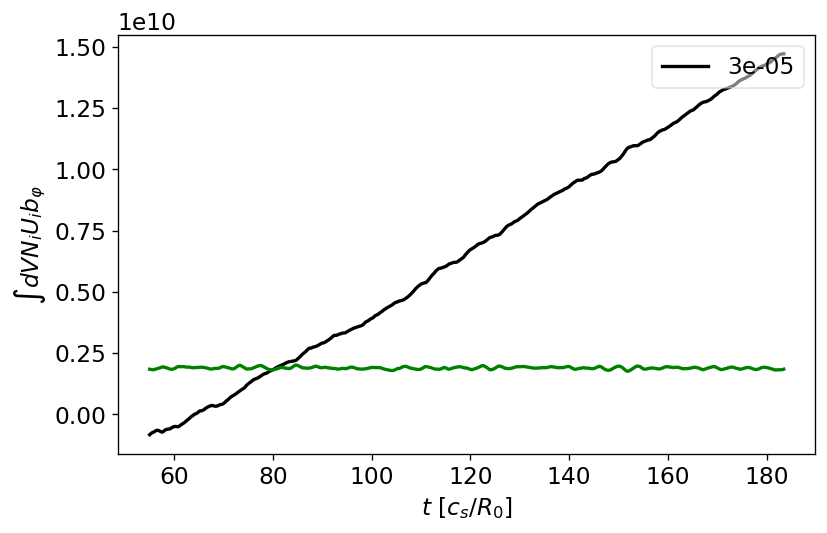

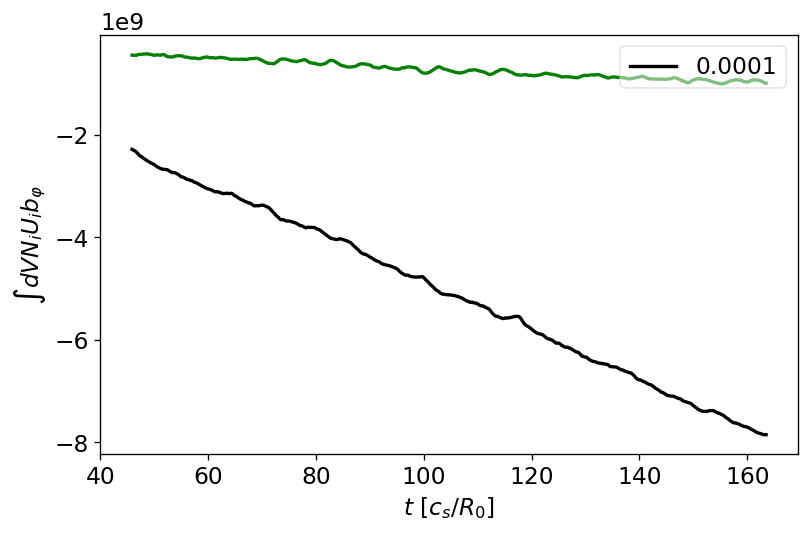

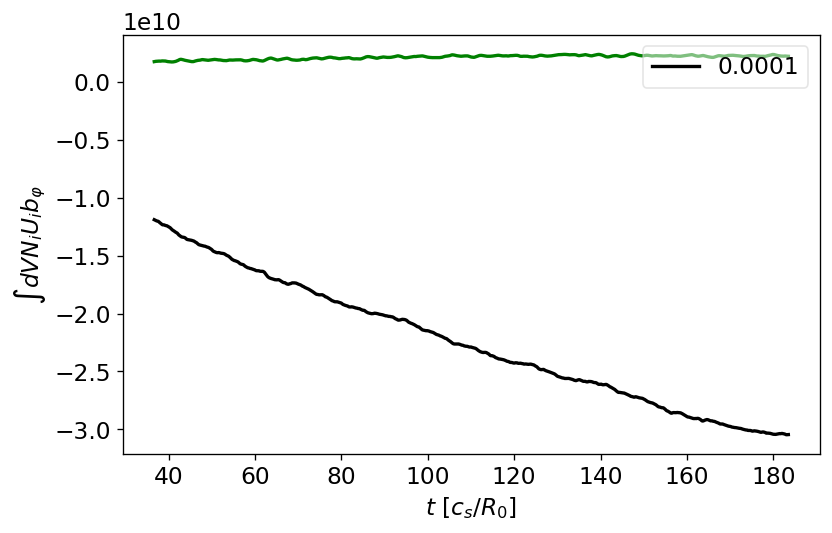

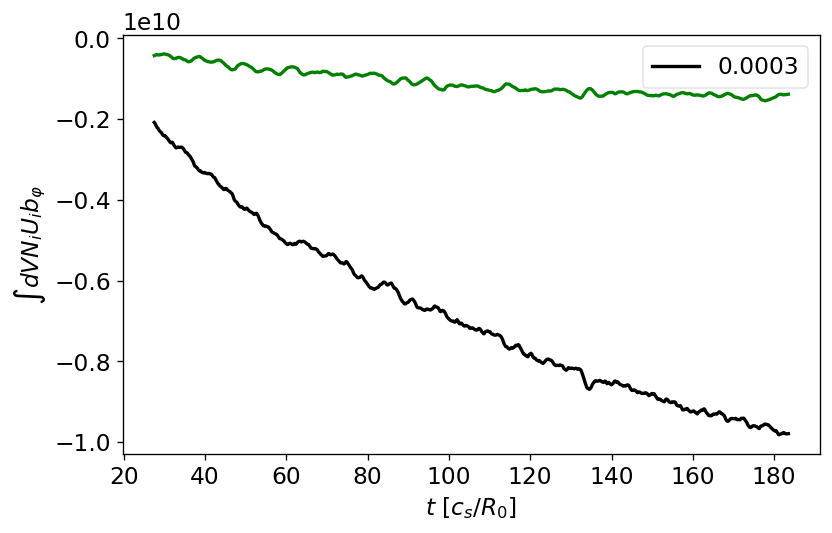

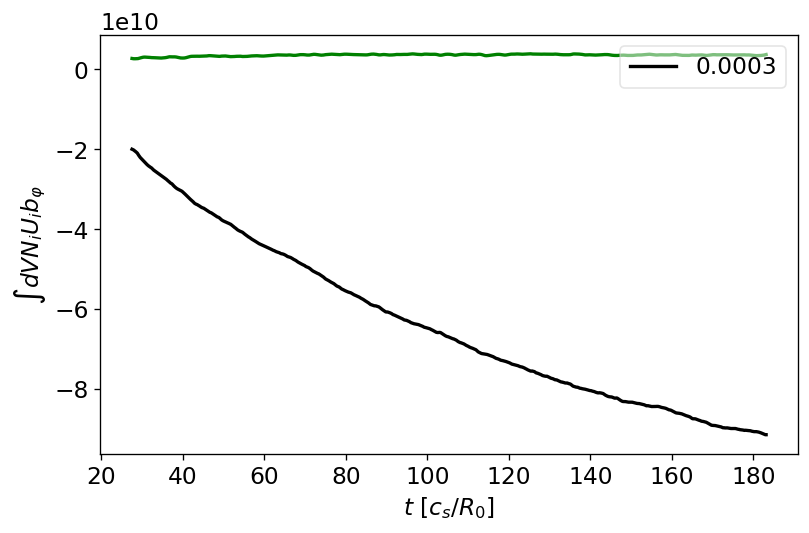

In [24]:
for pp in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = da.variables['time'][:]*timescale
    
    niuibphi = da.variables['niuibphi_ifs_lcfs'][:]
    oexb = da.variables['oexbi_ifs_lcfs'][:]*543
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=2,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
    plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
         marker='',ls='-', lw=2,markeredgecolor='k', markersize=8
         )
#     plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
#          marker='',ls='-', lw=2,markeredgecolor='r', markersize=8
#          )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
#     da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\int dV  N_iU_ib_\varphi$")

    plt.show(   )

### Vorticity analysis

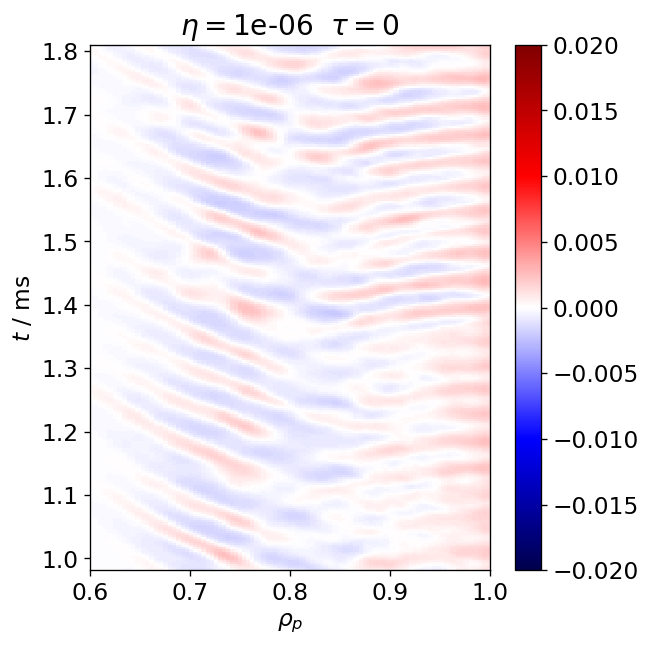

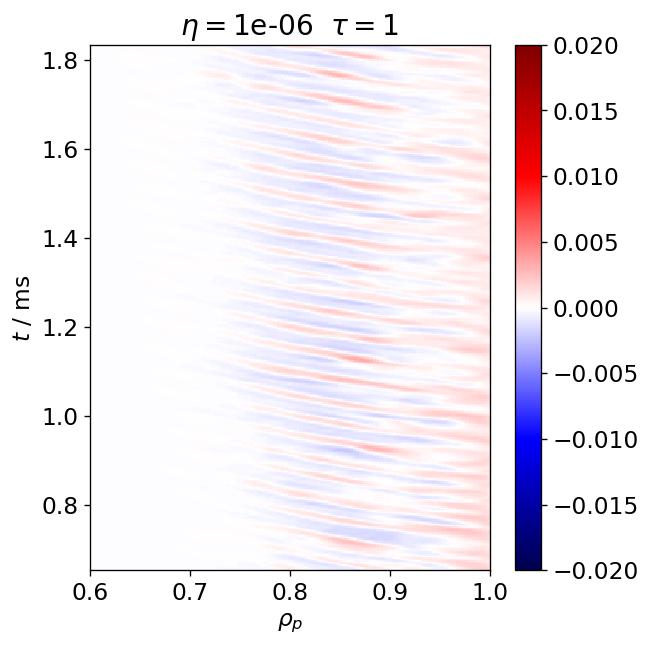

In [25]:
for pp in content :
    res = pp["physical"]["resistivity"] 
    tau = pp["physical"]["tau"]
    if res == 1e-6:
        fig,ax=plt.subplots(1,1,figsize=(1.45*3.7,1.45*4),dpi= 120, facecolor='w', edgecolor='k')
        da = pp['file']

        timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
    #     timescale = 1/num['R_0']# in cs/R_0
        time = da['time'][:]*timescale
        rho = pp['rho_p'][:]
    #     idx = 167
#         oexb = da['oexbe_fsa'][:,:]/ da['electrons_fsa']
#         oexb = da['odiae_fsa'][:,:]/ da['electrons_fsa']
        oexb = da['socurve_tt_fsa'][:,:]
        min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    #     plt.plot(time[min_idx:],oexb[min_idx:,idx], color='k', 

        pcm = ax.pcolormesh( rho, time[min_idx:], oexb[min_idx: ,],
                        vmin = -0.02000000, vmax = 0.02000000,
                        shading='auto', # more pixely
        #                 shading='gouraud',
                        cmap="seismic",
                        rasterized=True)
    #     da.close()
        
        plt.xlabel(r"$\rho_p$")
        plt.ylabel(r"$t$ / ms")
    #     ax.set_aspect('equal')
    #     plt.ylabel(r"$\langle \nabla \cdot( N_i \nabla_\perp \phi / B^2) \rangle$")
        fig.colorbar(pcm, ax=ax,)
        plt.xlim([0.6,1])
#         plt.savefig( 'new-zf-evolution-'+str(tau)+str(res)+'.png',bbox_inches='tight')
        plt.title( r"$\eta = $"+ str(res) + r"  $\tau = $" + str(tau) ) 
        plt.show(   )

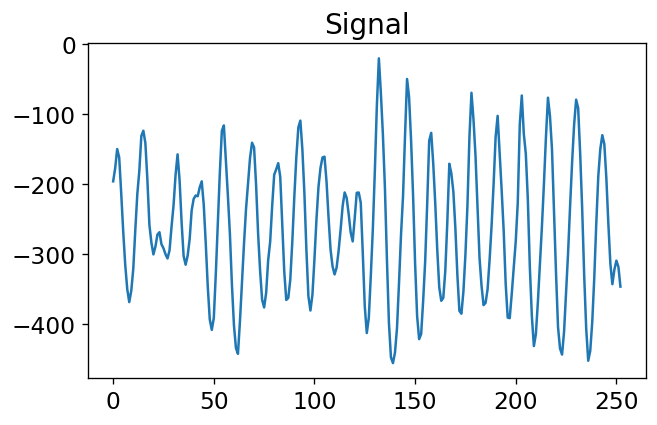

GAM in Omega_ci 0.001841620626151013
16 21 126
Max frequency  0.0003968253968253968


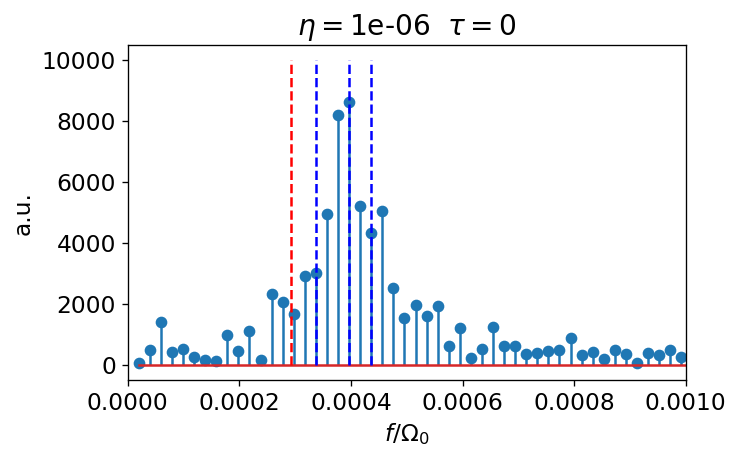

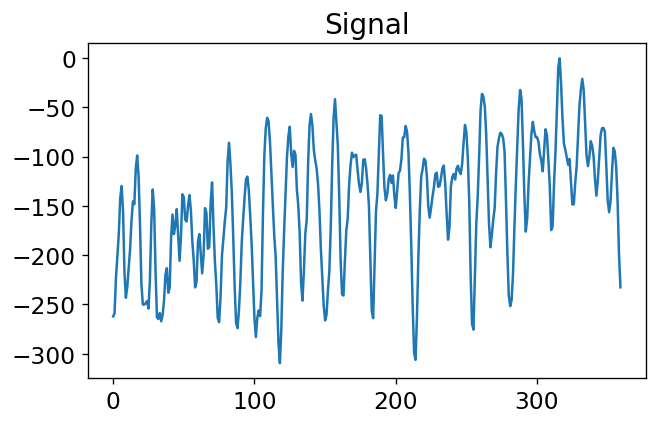

GAM in Omega_ci 0.001841620626151013
0 2 180
Max frequency  1.3927576601671309e-05


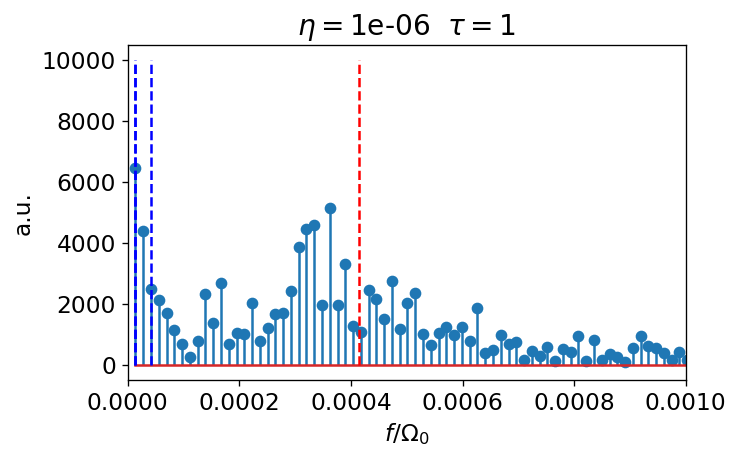

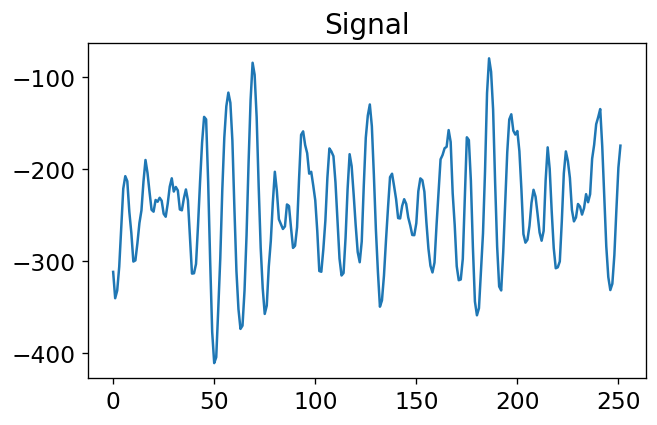

GAM in Omega_ci 0.001841620626151013
19 22 126
Max frequency  0.0004183266932270916


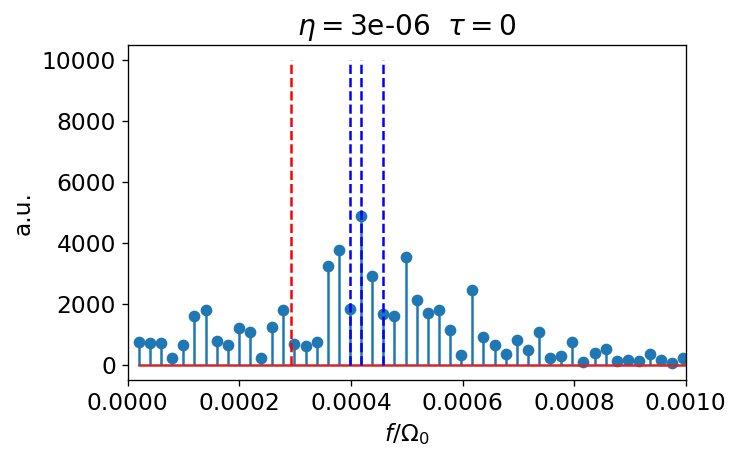

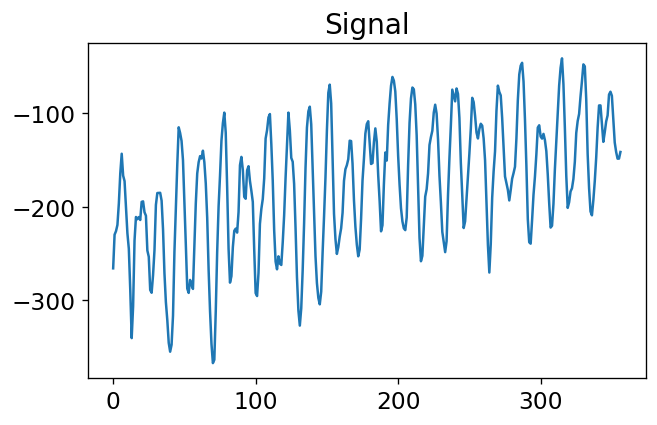

GAM in Omega_ci 0.001841620626151013
22 24 178
Max frequency  0.00033707865168539324


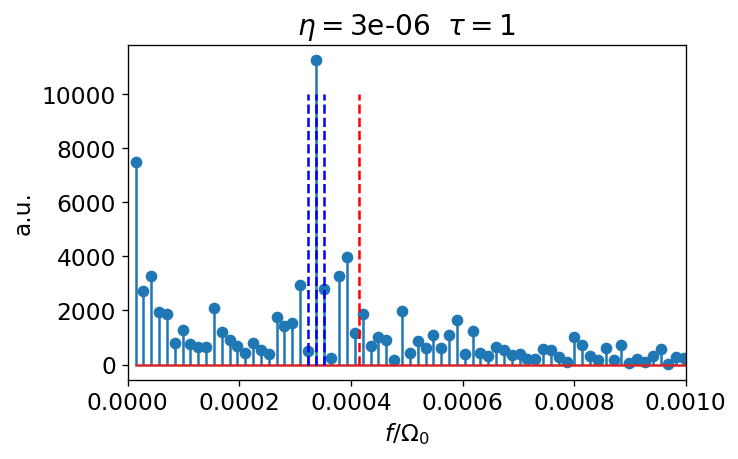

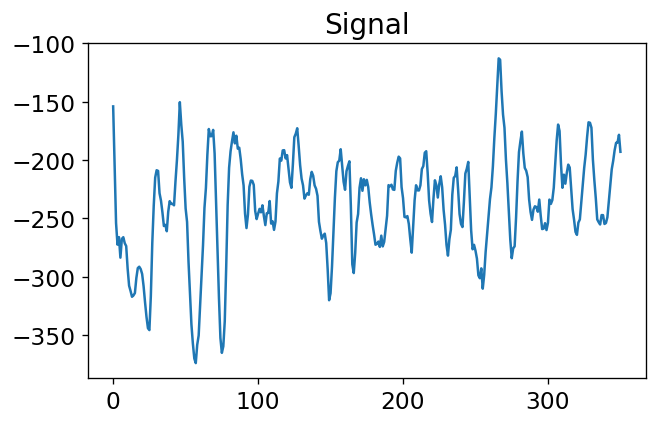

GAM in Omega_ci 0.001841620626151013
14 16 175
Max frequency  0.00030476190476190474


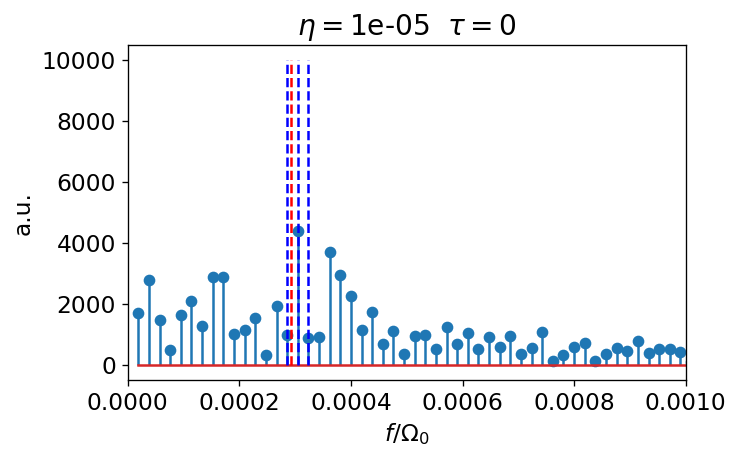

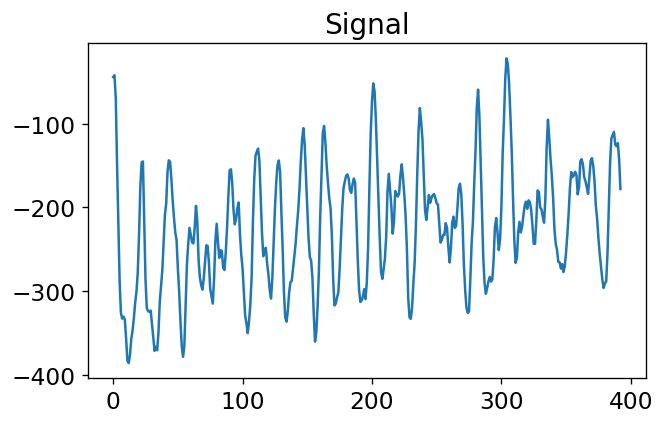

GAM in Omega_ci 0.001841620626151013
18 23 196
Max frequency  0.000391156462585034


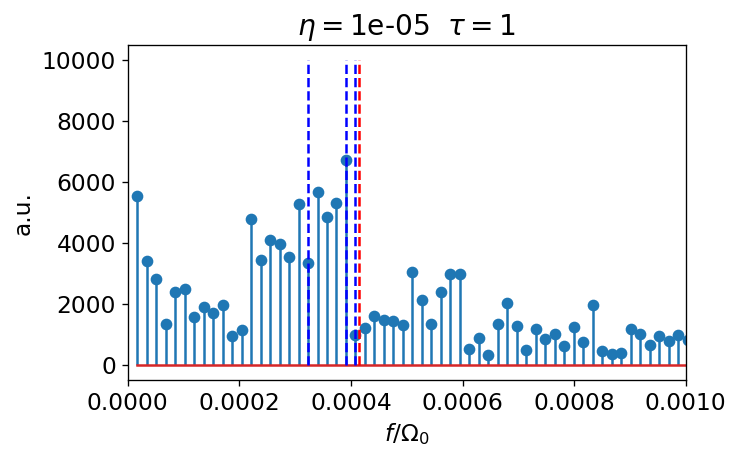

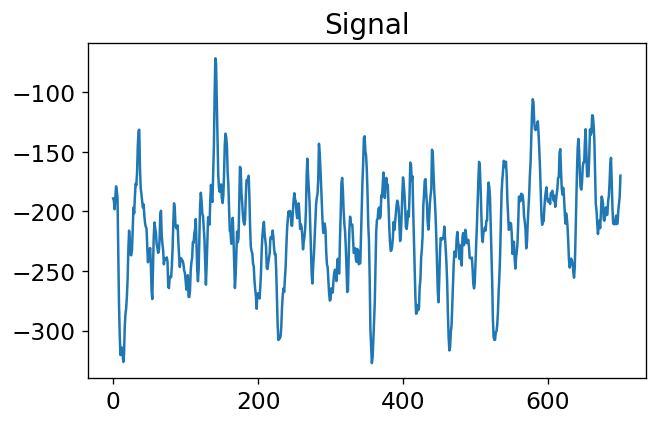

GAM in Omega_ci 0.001841620626151013
17 19 350
Max frequency  0.00027142857142857144


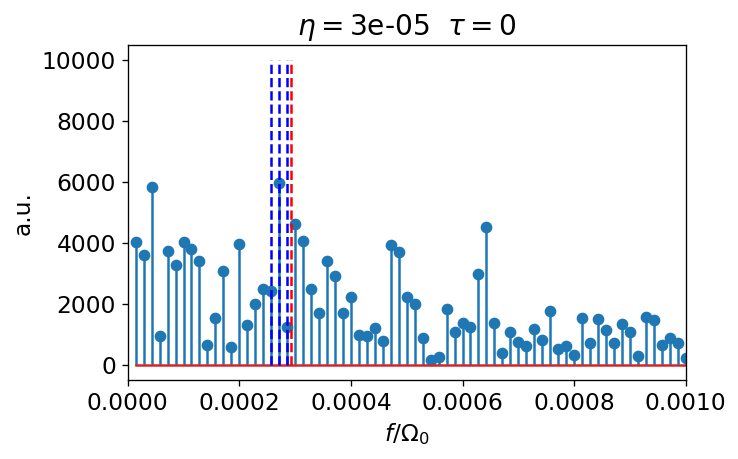

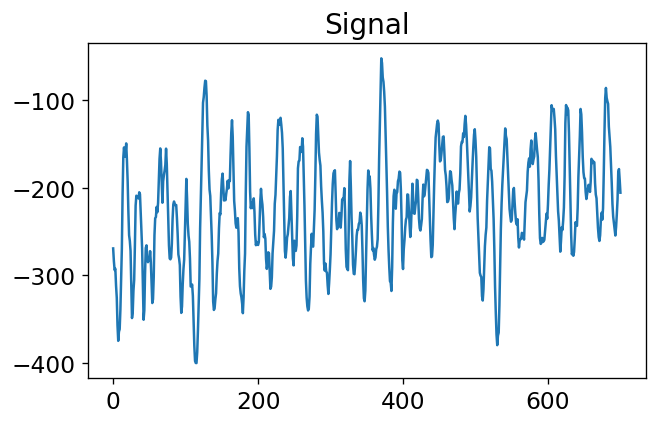

GAM in Omega_ci 0.001841620626151013
35 39 350
Max frequency  0.0005571428571428572


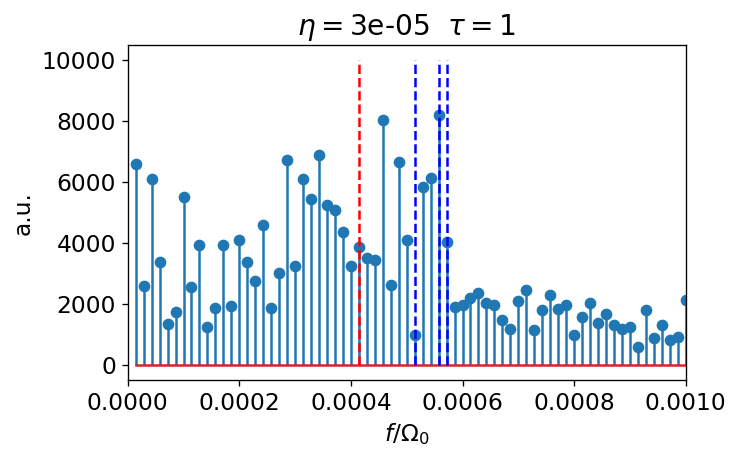

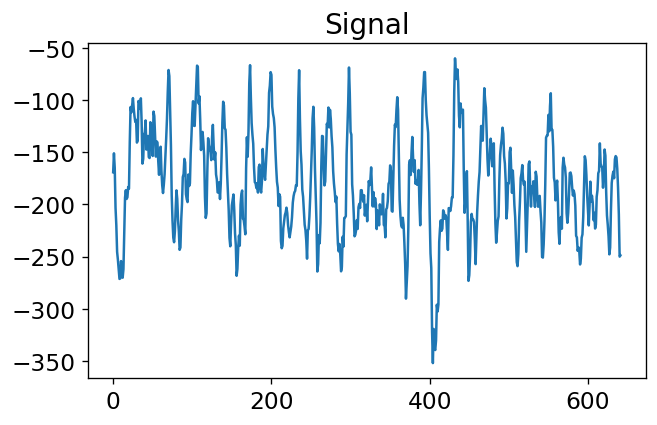

GAM in Omega_ci 0.001841620626151013
14 20 321
Max frequency  0.00024960998439937595


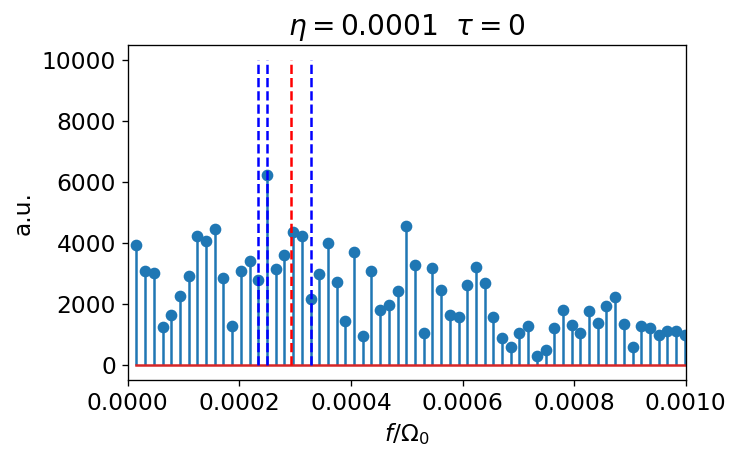

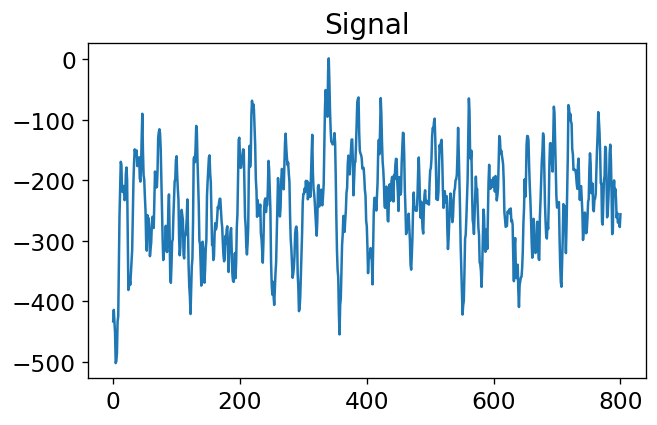

GAM in Omega_ci 0.001841620626151013
12 14 400
Max frequency  0.000175


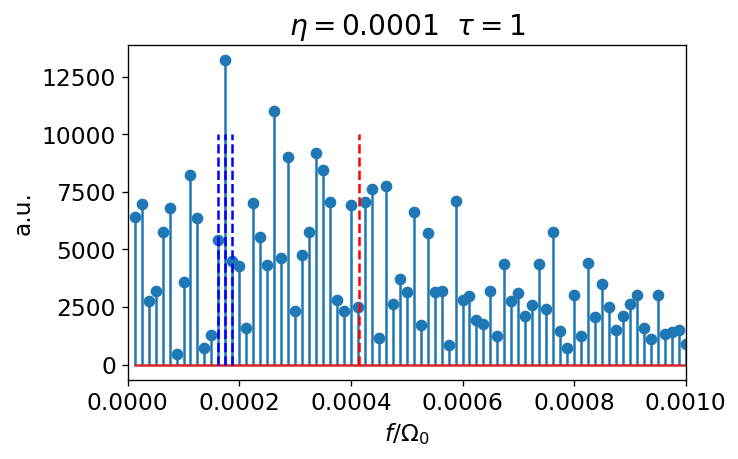

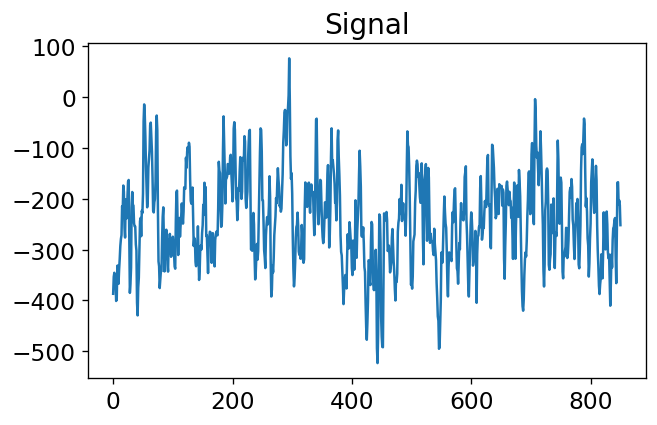

GAM in Omega_ci 0.001841620626151013
0 2 425
Max frequency  2.3529411764705884e-05


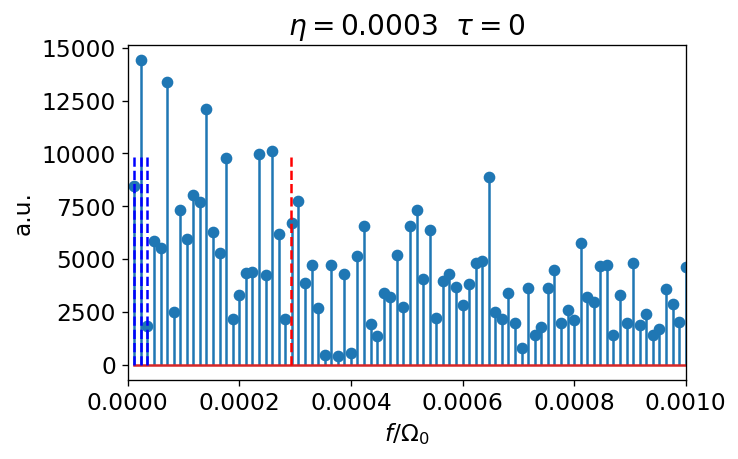

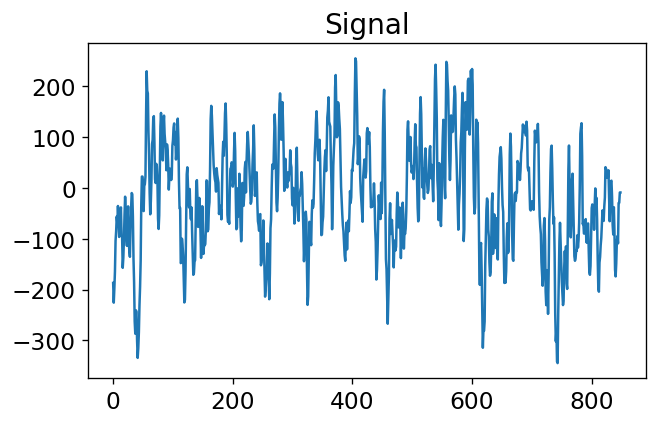

GAM in Omega_ci 0.001841620626151013
0 2 424
Max frequency  1.1792452830188679e-05


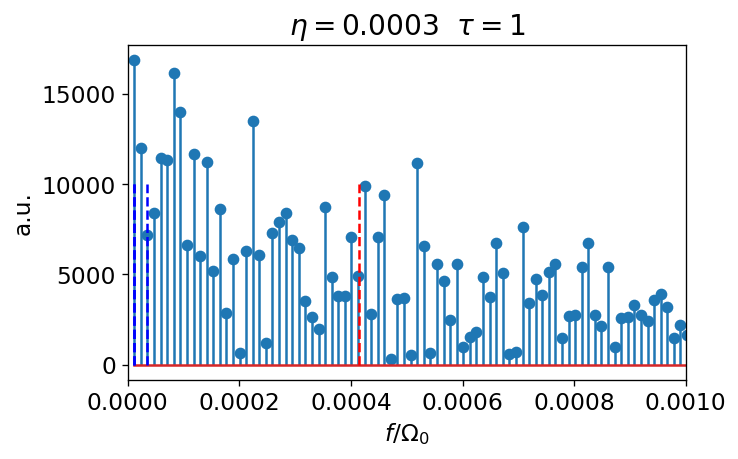

In [26]:
import scipy.signal as signal
# - subtract the mean before fft
# - do a sliding window analysis to get an error bar on the max frequency
for pp in content :
    res = pp["physical"]["resistivity"] 
    tau = pp["physical"]["tau"]

    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    da = pp['file']
    timescale = np.sqrt(1+tau)/543/2/np.pi
#         timescale = fp.omega_0_inv(**pp['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0
    time = np.asarray(da['time'][:])
    timett = np.append(time, 2*time[-1] -time[-2]) # extrapolate
    deltat = np.diff(timett)
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]

    jvne=np.asarray(da['divcurvne_tt_ifs_lcfs'][min_idx:])/deltat[min_idx]
#     jvne=np.asarray(da['oexbe_fsa'][min_idx:,167])#/deltat[min_idx]
    min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
    #### APPLY WINDOW FILTER
#     win = signal.windows.hann(10)
#     jvne = signal.convolve(jvne, win, mode='valid') / sum(win)
#     jvne = signal.savgol_filter( jvne, 10, 4)
#     if res == 1e-6 and tau == 0:
    plt.plot(  jvne)
    plt.title( "Signal")
    plt.show()
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 120, facecolor='w', edgecolor='k')
    dist = time[-1] - time[min_idx]
    fft_jvne = np.fft.rfft( jvne)[1:]
    xf = np.fft.rfftfreq(jvne.size, d=dist/jvne.size)[1:]
    af = np.abs(fft_jvne)
    plt.stem( xf, af)
    plt.vlines( timescale, ymin=0, ymax=10000, color='r', ls='--')
#     print( "GAM freq", np.sqrt(pp["physical"]["T_e"]+pp["physical"]["T_i"])/2/np.pi/pp["physical"]["R"])
    print( "GAM in Omega_ci", 1/543)
    plt.xlabel(r"$f / \Omega_0$")
    plt.ylabel(r"a.u.")
#     plt.ylim([0,10000])
    plt.xlim([0,0.001])
    max_idx = np.argmax(af)
    idxL = max_idx
    idxR = max_idx
    while idxL > 0 :
        if af[idxL] < af[max_idx]/2 :
            break
        idxL = idxL - 1 
    while idxR < np.size(xf)-1 :
        if af[idxR] < af[max_idx]/2 :
            break
        idxR = idxR + 1
    print( idxL, idxR, np.size(xf))
    plt.vlines( [xf[idxL],xf[max_idx],xf[idxR]], ymin=0, ymax=10000, color='b', ls='--')
             
    pp["physical"]["max_freq_jvne"] = xf[max_idx]
    pp["physical"]["fwhmL_freq_jvne"] = xf[idxL]
    pp["physical"]["fwhmR_freq_jvne"] = xf[idxR]
    print( "Max frequency ", pp["physical"]["max_freq_jvne"] )
    plt.title( r"$\eta = $"+ str(res) + r"  $\tau = $" + str(tau) ) 
    plt.show(   )

{0: [1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003], 1: [1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003]}


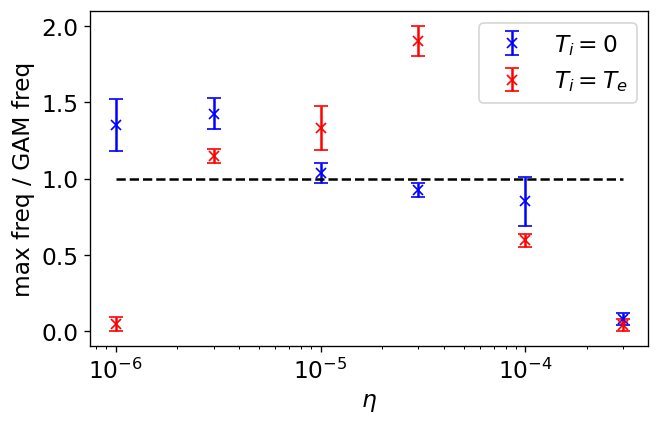

In [27]:
resistivities = {0: [], 1: []}
frequencies = {0: [], 1: []}
freq_err = {0: [], 1: []}
for pp in content:
    phys= pp['physical']
    resistivities[phys['tau']].append(phys['resistivity'])
    timescale = fp.omega_0_inv(**phys)*1e3 # ms
#     timescale = 1./545.# in cs/R_0
    frequencies[phys['tau']].append(
        phys['max_freq_jvne'])
    freq_err[phys['tau']].append(
        (phys['fwhmR_freq_jvne']-phys['fwhmL_freq_jvne'])/2)

print(resistivities)
##########################
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
# Plot error bar 
# label axes
scale = np.sqrt(1)/543/2/np.pi
# ax.plot( resistivities[0], frequencies[0]/scale,
#         marker='x', ls='',label=r'$\tau=0$',
#             color = 'b')
# scale = np.sqrt(1+1)/543/2/np.pi
# ax.plot( resistivities[1], frequencies[1]/scale,
#         marker='o', ls='',label=r'$\tau=1$',
#             color = 'r')
ax.errorbar( resistivities[0], frequencies[0]/scale,
             yerr=freq_err[0]/scale, marker='x', ls='',label=r'$T_i=0$',
            color = 'b',capsize=4)
ax.errorbar( resistivities[1], frequencies[1]/scale,
             yerr=freq_err[1]/scale, marker='x', ls='',label=r'$T_i=T_e$',
            color = 'r',capsize=4)
ax.hlines( 1., xmin= 1e-6, xmax = 3e-4, color = 'k', ls = '--')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel('max freq / GAM freq')
# Rewrite the y labels
# ax.yaxis.set_major_formatter(tck.StrMethodFormatter('{x:.2f}'))
# ax.yaxis.set_minor_formatter(tck.StrMethodFormatter('{x:.0f}'))
# ax.set_yticks( [10,30,100])
# plt.ylim([0,0.3])
plt.legend()
plt.savefig('new-max-freq.png',bbox_inches='tight')
plt.show()

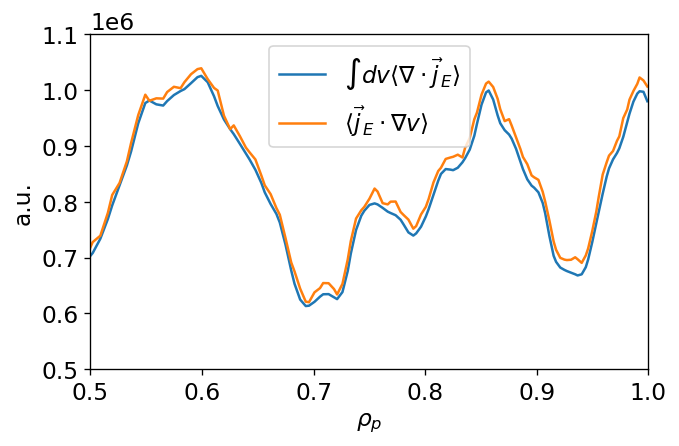

In [28]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-4
for pp in content:
    if pp["physical"]["tau"] == tau and pp["physical"]["resistivity"] == res:
        da = pp['file']
        ax.plot(  pp['rho_p'][0:168],  da["divneE_tt_ifs"][-1,0:168],#-da["divniE_tt_ifs"][-1,0:168])
                label = r"$\int d v \langle \nabla \cdot \vec j_E\rangle$")
        
        ax.plot(  pp['rho_p'][0:168],  da["jvneE_tt_fsa"][-1,0:168],#-da["jvniE_tt_fsa"][-1,0:168])
                label = r"$\langle \vec j_E \cdot \nabla v\rangle$")
plt.xlim([0.5,1])
plt.ylim([0.5e6, 1.1e6])
plt.legend()
plt.xlabel(r"$\rho_p$")
plt.ylabel("a.u.")
plt.savefig('div-j-comparison.png',bbox_inches='tight')
plt.show()

In [29]:
# tau = 1 res = 1e-4
ds = Dataset( "./resistivity-new-full-diag/3ec81972a93bd5b7efb96fff8f32a128e879b6ea0x9.nc")
da = xfeltor.open_feltordataset( "./resistivity-new-data/3ec81972a93bd5b7efb96fff8f32a128e879b6ea0x9.nc")
da0 = Dataset( "./resistivity-new-data/3ec81972a93bd5b7efb96fff8f32a128e879b6ea0x9.nc")

In [30]:
rational = list()
for val in [4/2,2.25,7/3,5/2,8/3,6/2]:
    rho_p = np.asarray( ds['rho_p'][:])
    q_prof = np.asarray(ds['q-profile'][:])
    rational.append(rho_p[(np.abs(q_prof-val)).argmin()] )
    print("val ", val, " rho_p ",rho_p[(np.abs(q_prof-val)).argmin()])
    
print( [0,2]+rational)
# for var in ds.variables:
#     print(var)


val  2.0  rho_p  0.40339411925956603
val  2.25  rho_p  0.6392978617009214
val  2.3333333333333335  rho_p  0.6929143723462098
val  2.5  rho_p  0.773443136703847
val  2.6666666666666665  rho_p  0.8398554297360605
val  3.0  rho_p  0.9247325707489392
[0, 2, 0.40339411925956603, 0.6392978617009214, 0.6929143723462098, 0.773443136703847, 0.8398554297360605, 0.9247325707489392]


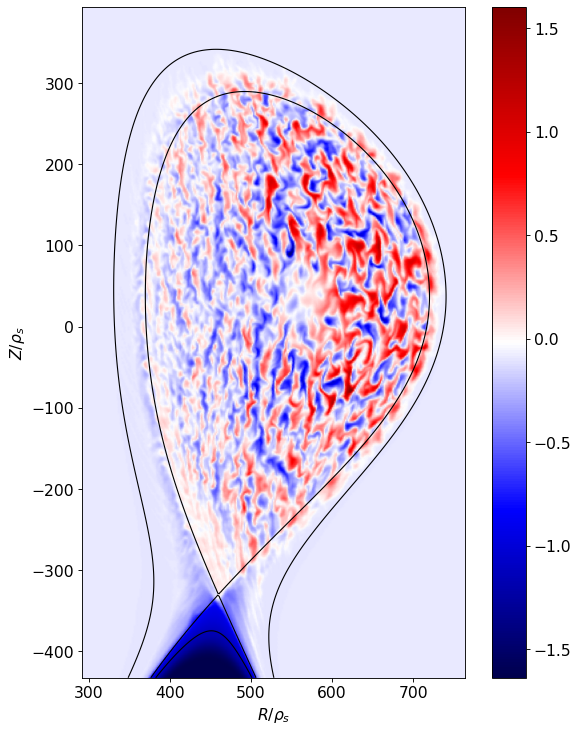

In [31]:

fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')
electrons_fsa = np.interp( da0['Psip2d'][:,:], ds['psi'][:],ds['electrons_fsa'][-1,:])
pcm = ax.pcolormesh( da['x'], da['y'],da["electrons_2d"][-1,:,:] - electrons_fsa,
#                 vmin=0.2,vmax=12,
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap='seismic',
#                 cmap='twilight_shifted',
              rasterized=True)
lvls=da.boundary["wall"]["boundary"]
im = ax.contour( da['x'], da['y'], da0['Rho_p'][:,:],
                levels=[1,lvls[0]], linewidths=1,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da0["Rho_p"][0:50,:],
                levels=[lvls[1]], linewidths=1,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.savefig( "ne-fluc2d.png",bbox_inches="tight")
plt.show()

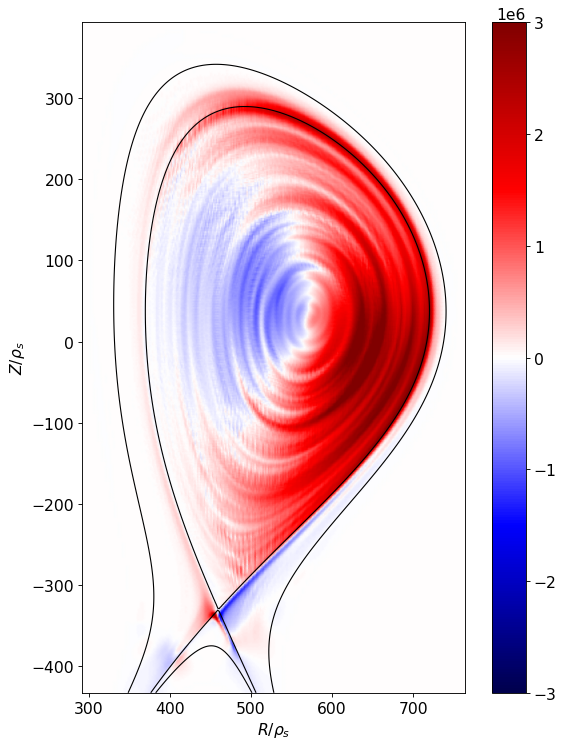

In [32]:

fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

pcm = ax.pcolormesh( da['x'], da['y'],ds['jvneE_tt_cta2d'][-1,:,:],
                vmin=-3e6,vmax=3e6,
#                 shading='auto', # more pixely
                shading='gouraud',
                cmap='seismic',
#                 cmap='twilight_shifted',
              rasterized=True)
lvls=da.boundary["wall"]["boundary"]
im = ax.contour( da['x'], da['y'], da0['Rho_p'][:,:],
                levels=[1,lvls[0]], linewidths=1,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da0["Rho_p"][0:50,:],
                levels=[lvls[1]], linewidths=1,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.savefig( "jvnE.png",bbox_inches="tight")
plt.show()

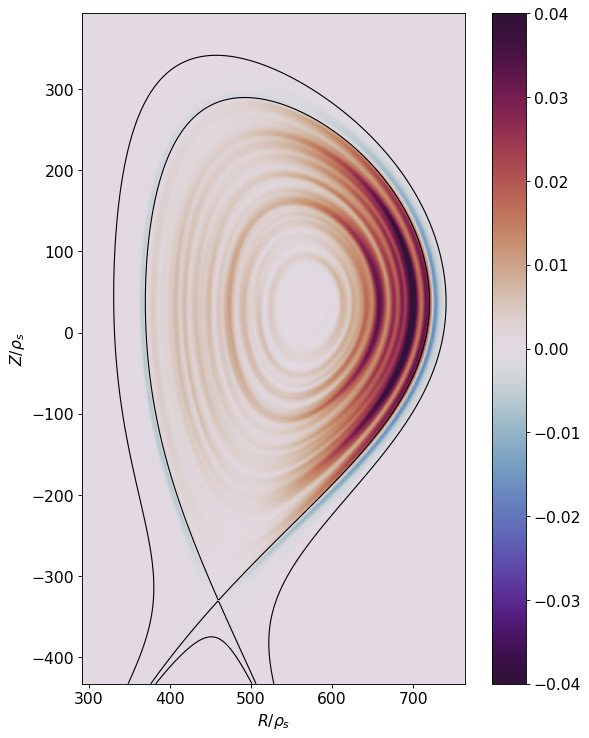

In [33]:

fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')

pcm = ax.pcolormesh( da['x'], da['y'],ds['oexbe_cta2d'][-1,:,:],
                vmin=-0.04,vmax=0.04,
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='seismic',
                cmap='twilight_shifted',
              rasterized=True)
lvls=da.boundary["wall"]["boundary"]
im = ax.contour( da['x'], da['y'], da0['Rho_p'][:,:],
                levels=[1,lvls[0]], linewidths=1,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da0["Rho_p"][0:50,:],
                levels=[lvls[1]], linewidths=1,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.savefig( "oexbe.png",bbox_inches="tight")
plt.show()

In [34]:
import convert
cmap = convert.xml2cmap( '../ColorMaps/Divergent/tr4.xml')
cmap = convert.xml2cmap( 'colormap(65).xml')

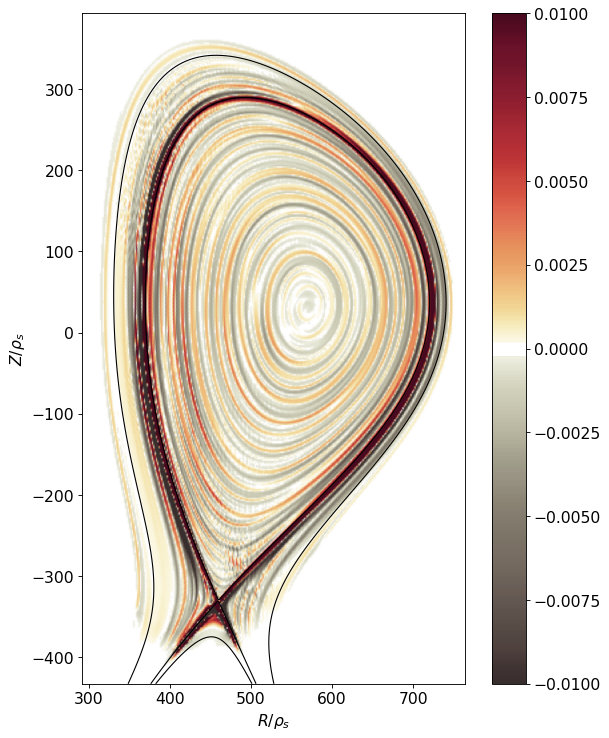

In [35]:

fig,ax=plt.subplots(1,1,figsize=(3*3,3*3.7),dpi= 80, facecolor='w', edgecolor='k')
norm = colors.SymLogNorm(1e-2, linscale=2, vmin=-1, vmax=1, clip=False)
pcm = ax.pcolormesh( da['x'], da['y'],ds['vorticity_cta2d'][-1,:,:],
                    vmin = -0.01, vmax = 0.01,
#                     norm = norm,
#                 shading='auto', # more pixely
                shading='gouraud',
#                 cmap='RdGy', 
                    cmap = cmap,
                  rasterized=True)
lvls=da.boundary["wall"]["boundary"]
im = ax.contour( da['x'], da['y'], da0['Rho_p'][:,:],
                levels=[1,lvls[0]], linewidths=1,colors='k')
im = ax.contour( da['x'], da['y'][0:50], da0["Rho_p"][0:50,:],
                levels=[lvls[1]], linewidths=1,colors='k')
fig.colorbar(pcm, ax=ax)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.savefig( "vorticity.png",bbox_inches="tight")
plt.show()

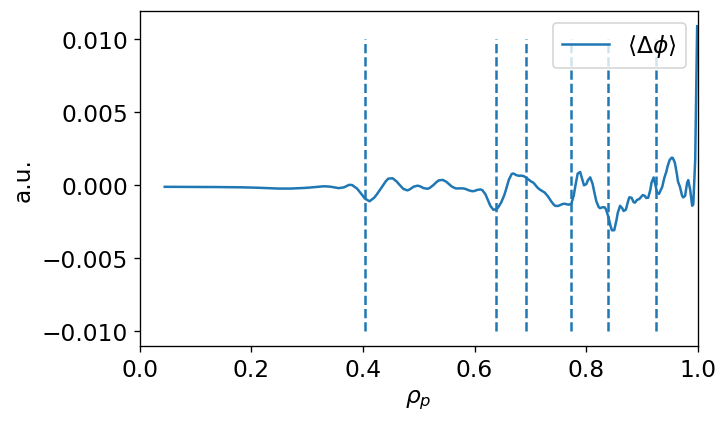

In [36]:
fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
tau = 1
res = 1e-5
for pp in content:
    if pp["physical"]["tau"] == tau and pp["physical"]["resistivity"] == res:
        da = pp['file']
        ax.plot(  pp['rho_p'][0:168],  da["vorticity_fsa"][-1,0:168],#-da["divniE_tt_ifs"][-1,0:168])
                label = r"$ \langle \Delta \phi \rangle$")
        
plt.vlines( rational, ymin = -0.01, ymax = 0.01, ls  = '--' )
plt.xlim([0.,1])
# plt.ylim([0.5e6, 1.1e6])
plt.legend()
plt.xlabel(r"$\rho_p$")
plt.ylabel("a.u.")
plt.savefig('vorticity-fsa-rational.png',bbox_inches='tight')
plt.show()

In [37]:
# tau = 1 res = 1e-5

ds = Dataset( "./resistivity-new-diag/bb9743ce9505b22bf7474671f3ecef8a340e83bf0x6.nc")
da = xfeltor.open_feltordataset( "./resistivity-new-data/bb9743ce9505b22bf7474671f3ecef8a340e83bf0x6.nc")
da0 = Dataset( "./resistivity-new-data/bb9743ce9505b22bf7474671f3ecef8a340e83bf0x6.nc")

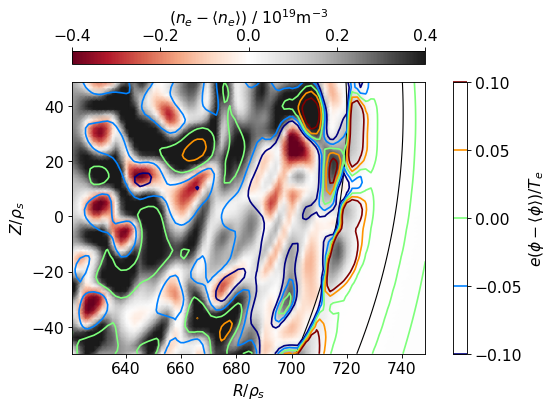

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig,ax=plt.subplots(1,1,figsize=(3*3,3*1.5),dpi= 80, facecolor='w', edgecolor='k')
norm = colors.SymLogNorm(1e-1, linscale=2, vmin=-1, vmax=1, clip=False)
electrons_fsa = np.interp( da0['Psip2d'][:,:], ds['psi'][:],ds['electrons_fsa'][-1,:])

potential_fsa = np.interp( da0['Psip2d'][:,:], ds['psi'][:],ds['potential_fsa'][-1,:])
x0 = 620
x1 = 750 
y0= -50
y1 = 50
xmin = np.argmin ( np.abs(np.asarray(da0['x']) - x0))
xmax = np.argmin ( np.abs(np.asarray(da0['x']) - x1))
ymin = np.argmin ( np.abs(np.asarray(da0['y']) - y0))
ymax = np.argmin ( np.abs(np.asarray(da0['y']) - y1))
pcm = ax.pcolormesh( da0['x'][xmin:xmax], da0['y'][ymin:ymax],
                    (da0['electrons_2d'][-1,ymin:ymax, xmin:xmax]-electrons_fsa[ymin:ymax, xmin:xmax]
                    ),
                    vmin = -0.4, vmax = 0.4,
                shading='gouraud',
                cmap='RdGy', 
#                     cmap = cmap,
                  rasterized=True)

lvls=da.boundary["wall"]["boundary"]
im = ax.contour( da['x'][xmin:xmax], da['y'][ymin:ymax],
                da0['Rho_p'][ymin:ymax, xmin:xmax],
                levels=[1,lvls[0]], linewidths=1,colors='k')

im = ax.contour( da['x'][ xmin:xmax], da['y'][ymin:ymax],
                da0['potential_2d'][-1,ymin:ymax, xmin:xmax]-potential_fsa[ymin:ymax, xmin:xmax],
                levels = [-.1, -0.05,0,  0.05, .1], linewidths = 1.5, cmap = 'jet'
               )
# fig.colorbar(pcm, ax=ax, orientation = 'horizontal')
axins = inset_axes(ax,
                    width="100%",  
                    height="5%",
                    loc='upper center',
                    borderpad=-2, 
                   )

fig.colorbar(pcm, cax=axins, orientation="horizontal", label = r"$(n_e - \langle n_e\rangle )$ / $10^{19}$m$^{-3}$")
axins.xaxis.set_label_position('top')
axins.xaxis.set_ticks_position('top')
CB = fig.colorbar(im, ax=ax , label = r"$e(\phi - \langle \phi \rangle)/T_e$")
lines1 = CB.ax.get_children()
# lines1[2].set_linewidths([5]*5)
ax.set_aspect('equal')
ax.set_xlabel( r"$R/\rho_s$")
ax.set_ylabel( r"$Z/\rho_s$")
plt.savefig( "nephi.png",bbox_inches="tight")
plt.show()

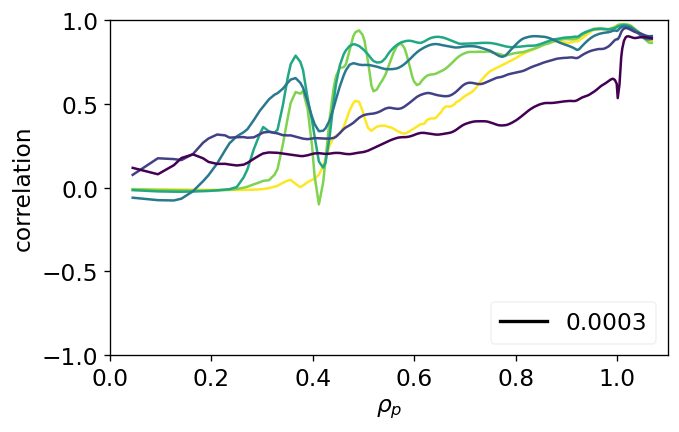

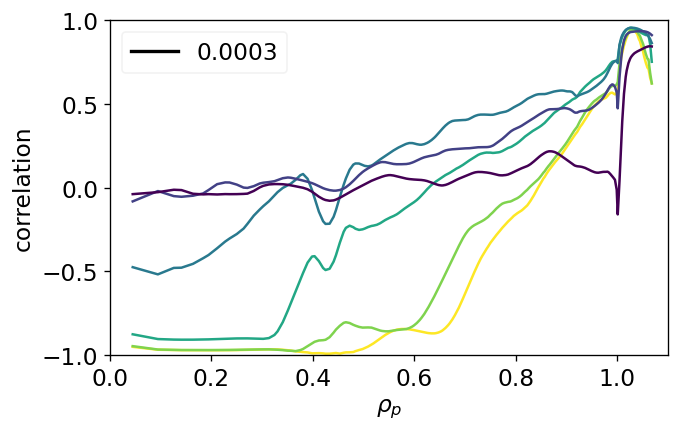

In [39]:

for tau in [0,1]:
    fig,ax=plt.subplots(1,1,figsize=(6,3.7), dpi= 120, facecolor='w', edgecolor='k')
    for pp in content:
        if pp["physical"]["tau"] == tau :
            da = pp['file']
            res = pp["physical"]["resistivity"]
            min_idx = min_idx_dict[pp["physical"]["tau"]][pp["physical"]["resistivity"]]
            density_std =np.sqrt( da['ne2_fsa'][min_idx:,:] - da['electrons_fsa'][min_idx:,:]**2) 
            potential_std =np.sqrt( da['phi2_fsa'][min_idx:,:] - da['potential_fsa'][min_idx:,:]**2)
        #         corr = (da['ne2_fsa'] - da['electrons_fsa']*da['electrons_fsa']
        #                )/density_std/density_std
            corr = (da['nephi_fsa'][min_idx:,:] - da['electrons_fsa'][min_idx:,:]*da['potential_fsa'][min_idx:,:]
                   )/density_std/potential_std
            ax.plot(  pp['rho_p'], 
#                     corr[-1,:],
                    corr.mean(axis = 0)[:],
                    color = cmp[res2idx[res]], label=f'{res}')
        
    plt.xlim([0.,1.1])
    plt.ylim([-1, 1])
    if tau == 0:
        plt.legend(handles, labels, loc='lower right',numpoints=1,ncol=2,
                               fontsize='medium',framealpha=0.25)
    if tau == 1:
        plt.legend(handles, labels, loc='upper left',numpoints=1,ncol=2,
                               fontsize='medium',framealpha=0.25)
    plt.xlabel(r"$\rho_p$")
    plt.ylabel("correlation")
    plt.savefig('nephicorrelation-'+str(tau)+'.png',bbox_inches='tight')
    plt.show()